# Курсовой проект:
Ваша задача этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и факт невыполнения кредитных обязательств) и test.csv (только признаки).

    train.csv - the training set
    test.csv - the test set
    sampleSubmission.csv - a sample submission file in the correct format

Data fields

    Home Ownership - домовладение
    Annual Income - годовой доход
    Years in current job - количество лет на текущем месте работы
    Tax Liens - налоговые обременения
    Number of Open Accounts - количество открытых счетов
    Years of Credit History - количество лет кредитной истории
    Maximum Open Credit - наибольший открытый кредит
    Number of Credit Problems - количество проблем с кредитом
    Months since last delinquent - количество месяцев с последней просрочки платежа
    Bankruptcies - банкротства
    Purpose - цель кредита
    Term - срок кредита
    Current Loan Amount - текущая сумма кредита
    Current Credit Balance - текущий кредитный баланс
    Monthly Debt - ежемесячный долг
    Credit Score - баллы кредитного рейтинга
    Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime
from matplotlib import rcParams

from sklearn.metrics import classification_report
from scipy.stats import mannwhitneyu


warnings.filterwarnings("ignore")

SEED = 2021
USE_CORES = os.cpu_count() - 1
# каталог с файлами: train.csv, test.csv и sample_submission.csv
# PATH_FILES = r'D:\python-txt\credit'
PATH_FILES = r'E:\temp'
# каталог с результатами работы
# PATH_EXPORT = r'D:\python-txt\credit'
PATH_EXPORT = r'E:\temp'
FILE_TRAIN = os.path.join(PATH_FILES, 'train.csv')
FILE_TEST = os.path.join(PATH_FILES, 'test.csv')
FILE_WITH_FEATURES = os.path.join(PATH_EXPORT, 'df_all.csv')
FILE_SAMPLE = os.path.join(PATH_EXPORT, 'sample_submission.csv')
FILE_SUBMIT = os.path.join(PATH_EXPORT, 'submission.csv')

rcParams.update({'font.size': 14})  # размер шрифта на графиках
pd.options.display.max_columns = 100
global_start_time = time.time()
    
%matplotlib inline    

In [2]:
def show_corr_matrix(df):
    plt.figure(figsize=(18, 12))
    sns.set(font_scale=1.4)
    corr_matrix = df[df.Learn == 1].drop('Learn', axis=1).corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) < 0.1] = 0
    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
    plt.title('Корреляция признаков')
    plt.show()
    
def show_plot_feature(feature, hue_on):
    legends = []
    fig, ax = plt.subplots(figsize=(18, 7))
    for element in sorted(dataset[hue_on].unique()):
        sns.kdeplot(dataset[(dataset[hue_on] == element)][feature], ax=ax)
        legends.append(f'Грп: {element}')
    ax.legend(legends)
    ax.set_xlim(dataset[feature].min(), dataset[feature].quantile(0.975))
    plt.title(f'Распределение признака {feature} в группах {hue_on}')
    plt.show()    

In [3]:
# обучающая выборка
train = pd.read_csv(FILE_TRAIN)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [4]:
train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [5]:
train.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

#### Посмотрим на целевую переменную

In [6]:
train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Видна разбалансировка классов.

In [7]:
# тестовая выборка
test = pd.read_csv(FILE_TEST)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

#### Посмотрим на распределение признаков на трейне

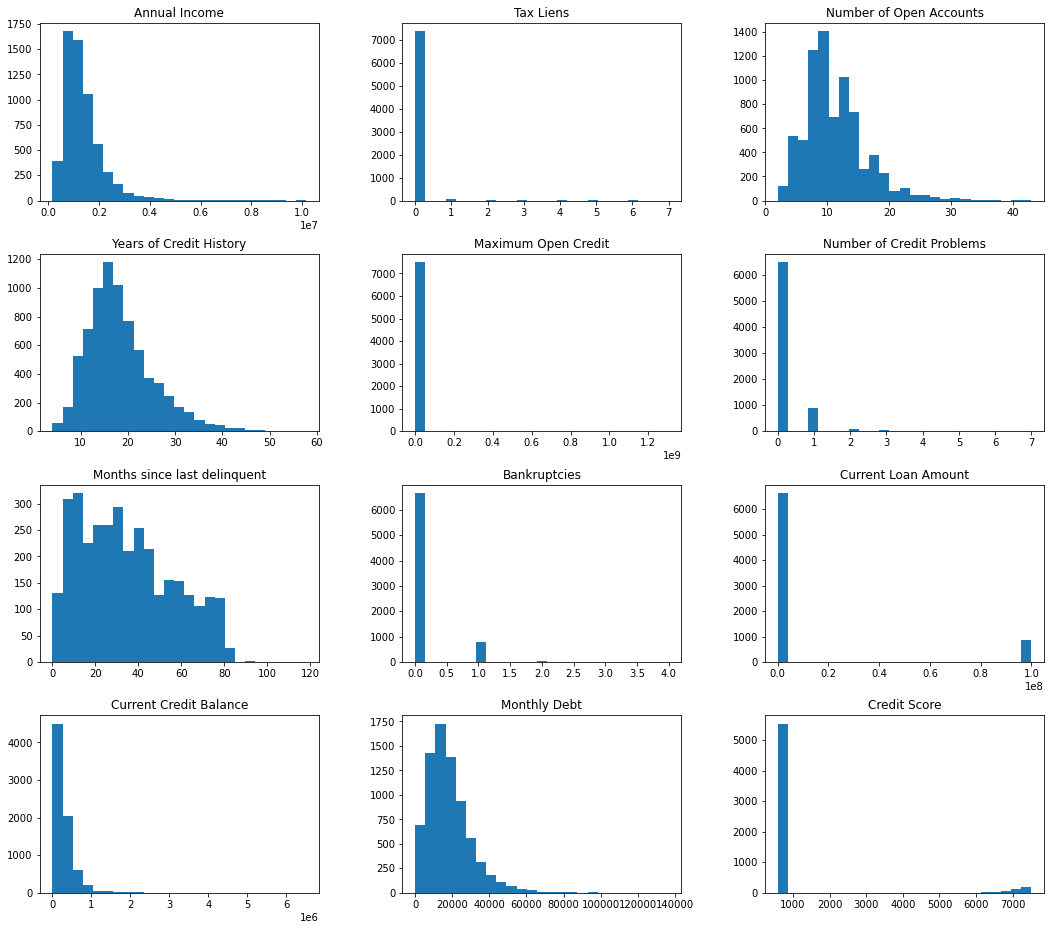

In [8]:
train.select_dtypes(include='float64').hist(figsize=(18,16), bins=25, grid=False, log=False)
plt.show()

Судя по гистограммам более пристально нужно посмотреть на признаки: Annual Income, Maximum Open Credit, Current Loan Amount, Current Credit Balance и Credit Score.

#### Посмотрим на распределение признаков на тесте

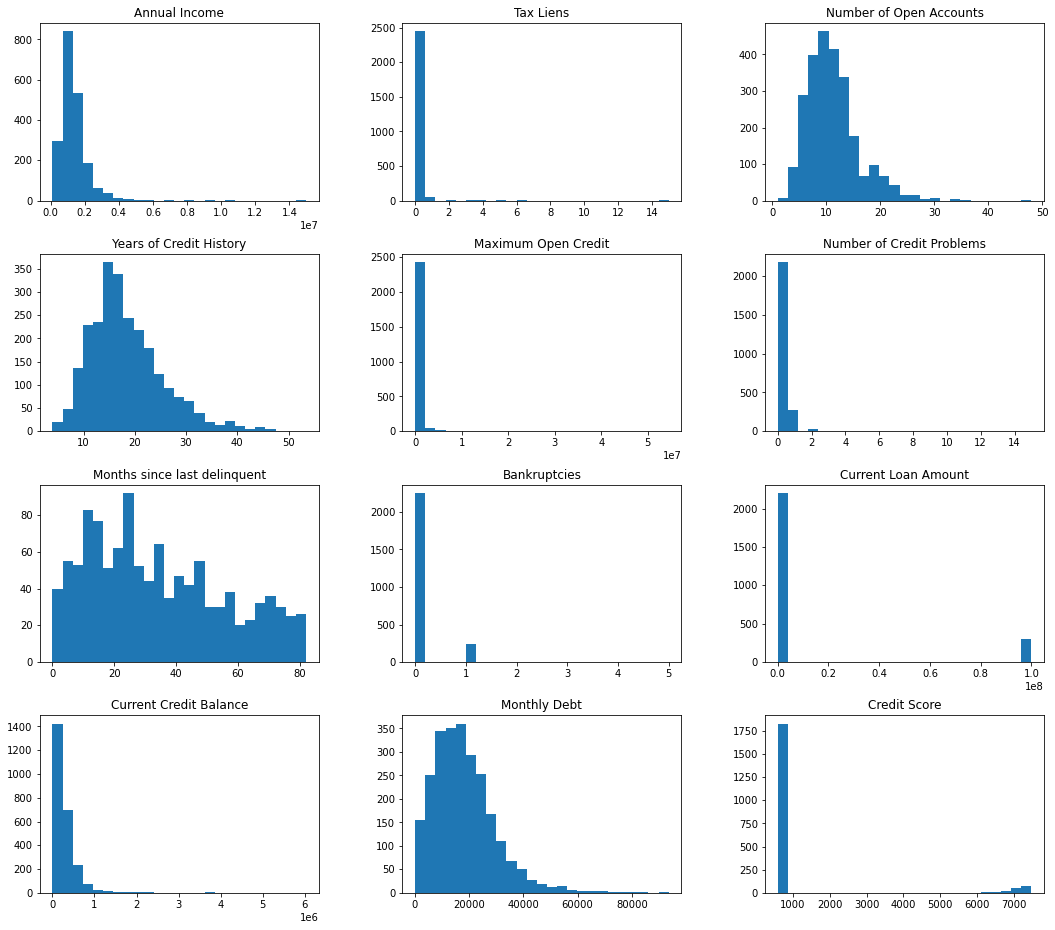

In [9]:
test.select_dtypes(include='float64').hist(figsize=(18,16), bins=25, grid=False, log=False)
plt.show()

In [10]:
# объединим обучающую и тестовую выборки в один датафрейм для 
# детального исследования, но перед этим заполним поле отметки выборок.
train['learn'] = 1
test['learn'] = 0
dataset = pd.concat([train, test])
dataset.columns = [x.title().replace(' ', '') for x in dataset.columns.values]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomeOwnership              10000 non-null  object 
 1   AnnualIncome               7930 non-null   float64
 2   YearsInCurrentJob          9543 non-null   object 
 3   TaxLiens                   10000 non-null  float64
 4   NumberOfOpenAccounts       10000 non-null  float64
 5   YearsOfCreditHistory       10000 non-null  float64
 6   MaximumOpenCredit          10000 non-null  float64
 7   NumberOfCreditProblems     10000 non-null  float64
 8   MonthsSinceLastDelinquent  4561 non-null   float64
 9   Bankruptcies               9983 non-null   float64
 10  Purpose                    10000 non-null  object 
 11  Term                       10000 non-null  object 
 12  CurrentLoanAmount          10000 non-null  float64
 13  CurrentCreditBalance       10000 non-null  floa

In [11]:
dataset.head()

HomeOwnership  AnnualIncome YearsInCurrentJob  TaxLiens  \
0       Own Home      482087.0               NaN       0.0   
1       Own Home     1025487.0         10+ years       0.0   
2  Home Mortgage      751412.0           8 years       0.0   
3       Own Home      805068.0           6 years       0.0   
4           Rent      776264.0           8 years       0.0   

   NumberOfOpenAccounts  YearsOfCreditHistory  MaximumOpenCredit  \
0                  11.0                  26.3           685960.0   
1                  15.0                  15.3          1181730.0   
2                  11.0                  35.0          1182434.0   
3                   8.0                  22.5           147400.0   
4                  13.0                  13.6           385836.0   

   NumberOfCreditProblems  MonthsSinceLastDelinquent  Bankruptcies  \
0                     1.0                        NaN           1.0   
1                     0.0                        NaN           0.0   
2                     0.0                        NaN           0.0   
3                     1.0                        NaN           1.0   
4                     1.0                        NaN           0.0   

              Purpose        Term  CurrentLoanAmount  CurrentCreditBalance  \
0  debt consolidation  Short Term         99999999.0               47386.0   
1  debt consolidation   Long Term           264968.0              394972.0   
2  debt consolidation  Short Term         99999999.0              308389.0   
3  debt consolidation  Short Term           121396.0               95855.0   
4  debt consolidation  Short Term           125840.0               93309.0   

   MonthlyDebt  CreditScore  CreditDefault  Learn  
0       7914.0        749.0            0.0      1  
1      18373.0        737.0            1.0      1  
2      13651.0        742.0            0.0      1  
3      11338.0        694.0            0.0      1  
4       7180.0        719.0            0.0      1

#### Посмотрим на 10 самых больших значений
В признаках  Annual Income, Maximum Open Credit, Current Loan Amount, Current Credit Balance и Credit Score.

In [12]:
suspect_cols = ['AnnualIncome', 'MaximumOpenCredit', 'CurrentLoanAmount', 'CurrentCreditBalance', 'CreditScore']
for col in suspect_cols:
    print(f'Признак: {col}:')
    print(dataset.nlargest(10, col)[col].to_list(), '\n')

Признак: AnnualIncome:
[14975610.0, 14934114.0, 10275770.0, 10149344.0, 9338880.0, 9163985.0, 8923844.0, 8758449.0, 8710740.0, 8633790.0] 

Признак: MaximumOpenCredit:
[1304726170.0, 380052288.0, 265512874.0, 57562560.0, 54484386.0, 40923894.0, 26406996.0, 26343328.0, 26069956.0, 21372428.0] 

Признак: CurrentLoanAmount:
[99999999.0, 99999999.0, 99999999.0, 99999999.0, 99999999.0, 99999999.0, 99999999.0, 99999999.0, 99999999.0, 99999999.0] 

Признак: CurrentCreditBalance:
[6506797.0, 6030087.0, 5176018.0, 4720132.0, 4489054.0, 4367245.0, 4304051.0, 4249673.0, 4209659.0, 3962298.0] 

Признак: CreditScore:
[7510.0, 7510.0, 7500.0, 7500.0, 7490.0, 7490.0, 7480.0, 7480.0, 7480.0, 7480.0] 



- MaximumOpenCredit - 3 макс.значения кажутся подозрительными. Возможно нужно удалить эти строки.
- CurrentLoanAmount - 99999999.0 - явные выбросы, нужно их как-то заменять.
- CreditScore - 75% квантиль = 743, тут явно ошиблись в разрядности: значения выше 1000 поделим на 10.

In [13]:
dataset[dataset.CreditScore >750].CreditScore.value_counts()

751.0     77
7400.0    23
7370.0    21
7330.0    17
7170.0    15
          ..
6600.0     1
6280.0     1
6270.0     1
6450.0     1
6390.0     1
Name: CreditScore, Length: 118, dtype: int64

In [14]:
show_cols = ['TaxLiens', 'NumberOfCreditProblems', 'NumberOfOpenAccounts', 'YearsOfCreditHistory', 'Bankruptcies']
for colname in show_cols:
    print(str(colname) + '\n\n' + str(dataset[colname].value_counts()) + '\n' + '*' * 44 + '\n')

TaxLiens

0.0     9811
1.0      128
2.0       35
3.0       11
4.0        7
5.0        3
6.0        3
15.0       1
7.0        1
Name: TaxLiens, dtype: int64
********************************************

NumberOfCreditProblems

0.0     8646
1.0     1162
2.0      122
3.0       42
5.0       11
4.0       10
6.0        4
7.0        2
15.0       1
Name: NumberOfCreditProblems, dtype: int64
********************************************

NumberOfOpenAccounts

9.0     973
11.0    903
10.0    895
8.0     861
7.0     789
12.0    766
6.0     687
13.0    643
14.0    579
5.0     431
15.0    410
16.0    346
17.0    298
4.0     275
18.0    195
19.0    185
20.0    130
3.0     124
21.0    107
23.0     76
22.0     75
24.0     59
25.0     38
2.0      35
27.0     24
26.0     17
28.0     17
30.0     17
29.0     11
33.0      8
31.0      7
32.0      6
34.0      3
37.0      2
41.0      1
48.0      1
38.0      1
1.0       1
36.0      1
42.0      1
35.0      1
43.0      1
Name: NumberOfOpenAccounts, dtype: int64
*

**Обзор номинативных признаков**

In [15]:
for cat_colname in dataset.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(dataset[cat_colname].value_counts()) + '\n' + '*' * 44 + '\n')

HomeOwnership

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: HomeOwnership, dtype: int64
********************************************

YearsInCurrentJob

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: YearsInCurrentJob, dtype: int64
********************************************

Purpose

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation                  11
renewable energy           2
Name: Purpose, dtype: int64
********************************************

### Обработка пропусков

In [16]:
dataset.drop(['CreditDefault', 'Learn'], axis=1).isna().sum()

HomeOwnership                   0
AnnualIncome                 2070
YearsInCurrentJob             457
TaxLiens                        0
NumberOfOpenAccounts            0
YearsOfCreditHistory            0
MaximumOpenCredit               0
NumberOfCreditProblems          0
MonthsSinceLastDelinquent    5439
Bankruptcies                   17
Purpose                         0
Term                            0
CurrentLoanAmount               0
CurrentCreditBalance            0
MonthlyDebt                     0
CreditScore                  2070
dtype: int64

#### Для определения стратегии заполнения пропусков и выбросов построим матрицу корреляций признаков и целевой переменной.

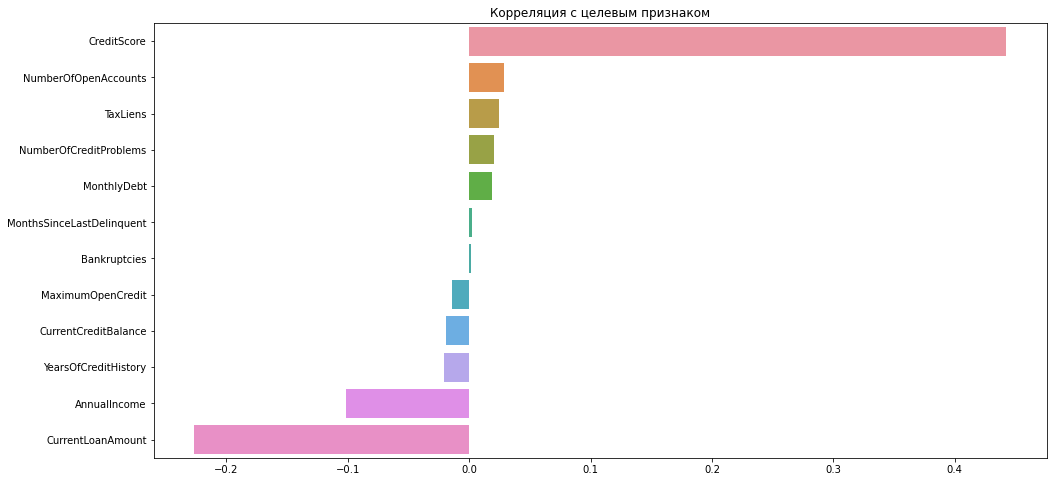

In [17]:
corr_with_target = dataset.drop('Learn', axis=1).corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(16, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция с целевым признаком')
plt.show()

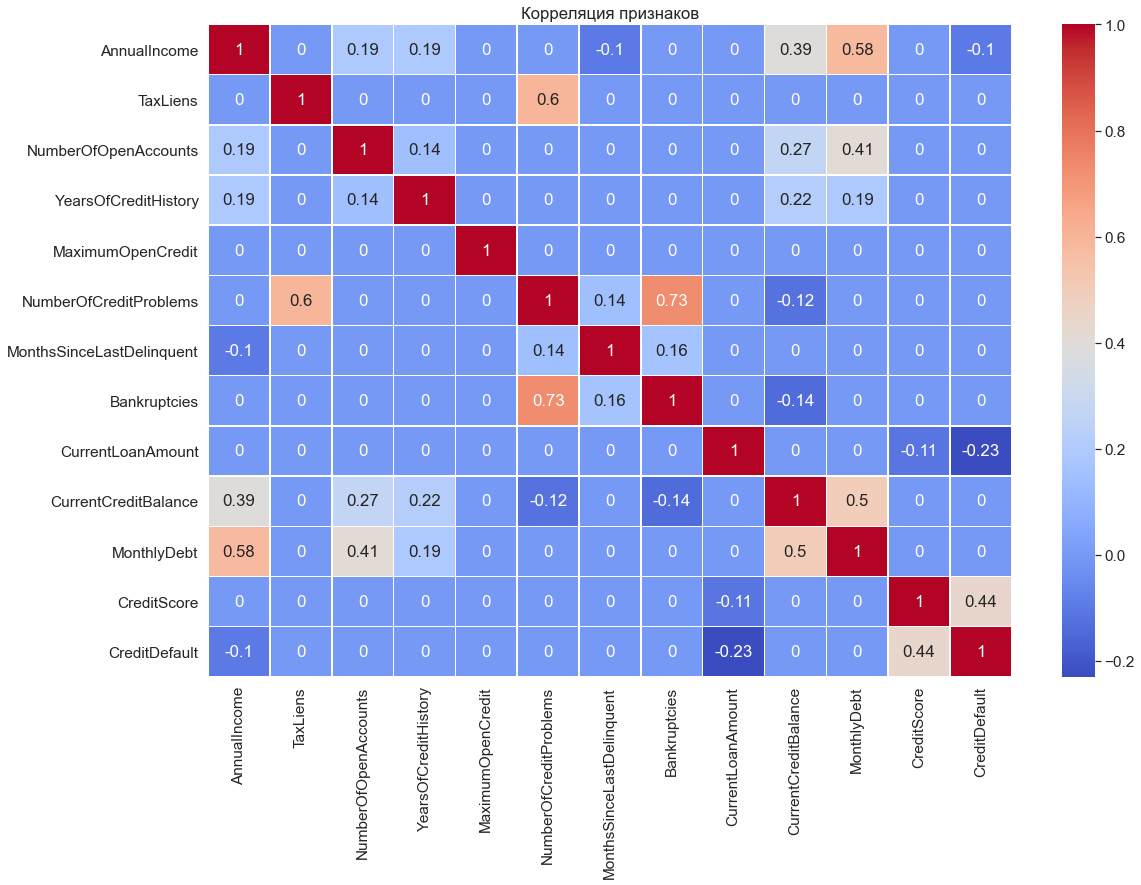

In [18]:
show_corr_matrix(dataset)

### Стратегия обработки данных:
- YearsInCurrentJob -  заполнить модой или модой по группировкам, и возможно поделить на группы: до 3-х лет, от 3-5 лет, 6-9лет, 10+.
- CreditScore - значения выше 1000 поделим на 10. Возможно, пропуски говорят о том, что до сих пор человек не брал кредит и нужно поставить ему начальный кредитный рейтинг - заполнить медианой или медианой по целям кредита или другим группировкам. Попробовать все варианты.
- Bankruptcies - пропуски заполнить нулями и привести к бинарному (есть факт банкротства или нет)
- MonthsSinceLastDelinquent (количество месяцев с последней просрочки платежа) - больше половины строк имеют пропуски. Возможно, пропуски говорят об отсутствии просрочек по платежам. Можно заполнить нулями или удалить этот признак. Попробовать заполнить медианой по группам.
- CurrentLoanAmount (текущая сумма кредита) - значения 999999999 заменить медианой по группировкам, т.к. у признака нет значимых корелляций с другими признаками.
- AnnualIncome (годовой доход) - у признака Средняя корреляция с MonthlyDebt, посмотреть на распределение. Принято решение разбить диапазон на 7 частей и найти медиану по этим группам. Исследования ниже.
- Пробовать заполнить пропуски и выбросы по группировкам по всем номинативным признакам, у которых количество значений 5 и более. Считаем медиану, среднее и среднее между медианой и средним.

In [19]:
dataset.MonthlyDebt.describe()

count     10000.000000
mean      18303.675600
std       11831.647516
min           0.000000
25%       10059.750000
50%       16200.000000
75%       23888.250000
max      136679.000000
Name: MonthlyDebt, dtype: float64

In [20]:
dataset.MonthlyDebt.quantile([0.2, 0.4, 0.6, 0.8, 1.])

0.2      8803.6
0.4     13784.8
0.6     18904.0
0.8     26162.0
1.0    136679.0
Name: MonthlyDebt, dtype: float64

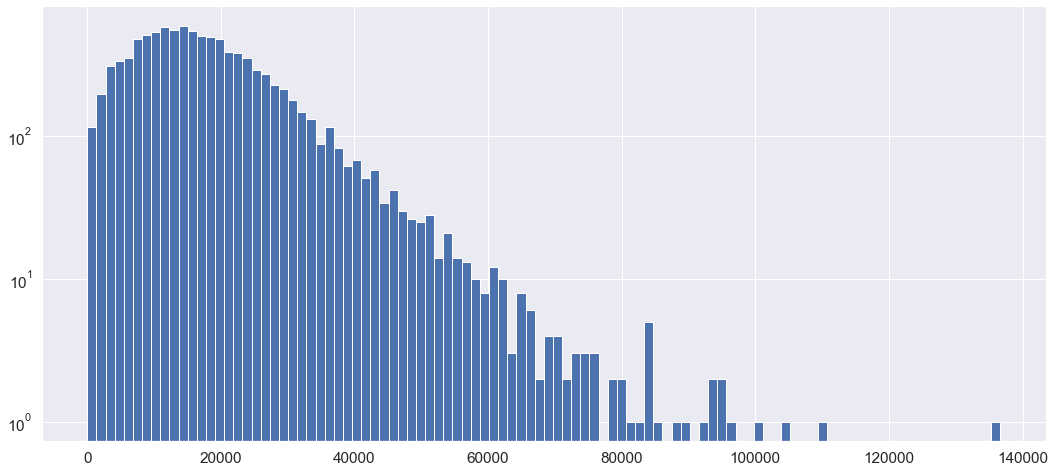

In [21]:
dataset.MonthlyDebt.hist(bins=100, figsize = (18, 8))
plt.yscale('log')
plt.show()

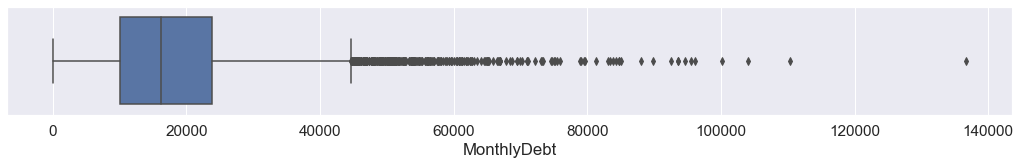

In [22]:
plt.figure(figsize=(18, 2))
sns.boxplot(data=dataset, x='MonthlyDebt')
plt.show()

### Построение новых признаков

Номинативные признаки преобразуем в бинарные и Dummies:
- Tax Liens в бинарный(есть налоговые обязательства или нет)
- Number of Credit Problems - уменьшим кол-во до 5
- Bankruptcies в бинарный (есть факт банкротства или нет)
- Term в бинарный вид
- Обработаем Purpose, разбив на 2 группы наиболее часто встречающихся и остальные
- Преобразуем Years in current job в числовые значения

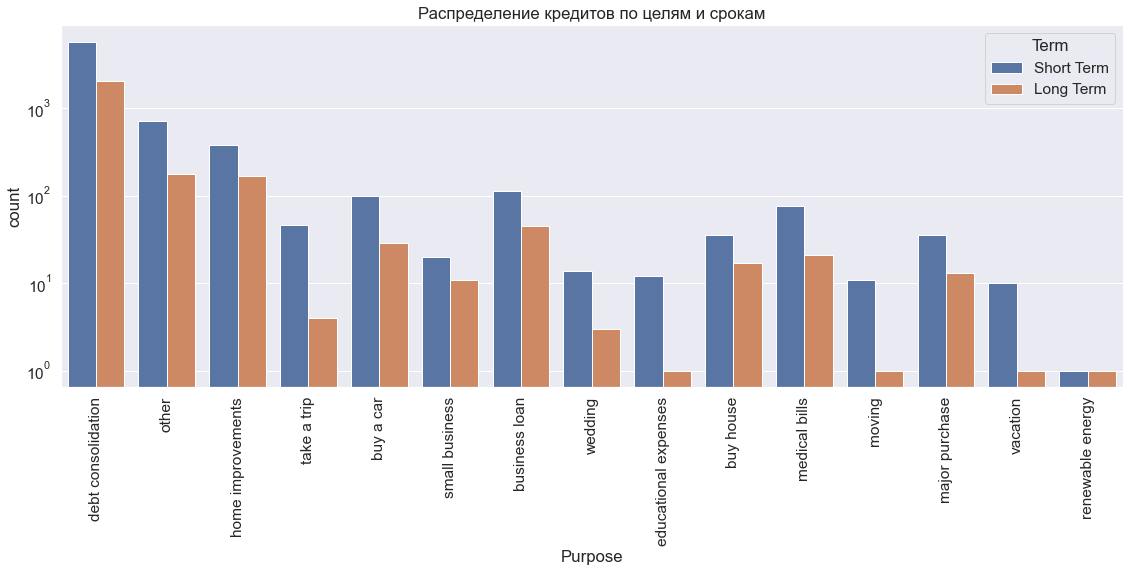

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(x='Purpose', hue='Term', data=dataset)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.yscale('log')
plt.tight_layout()
plt.title('Распределение кредитов по целям и срокам')
plt.show()

Преобразуем YearsInCurrentJob в числа и посмотрим корреляцию с другими признаками

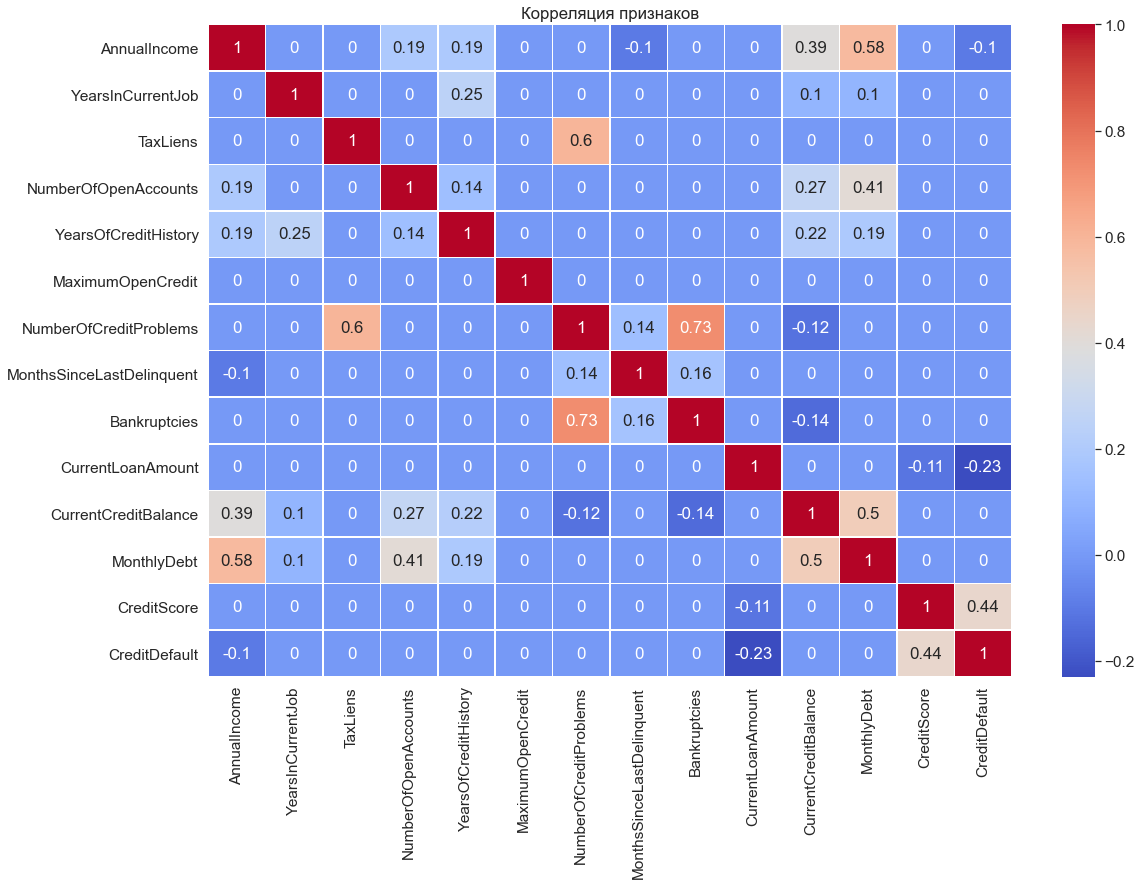

In [24]:
dataset.loc[dataset.YearsInCurrentJob.isnull(), 'YearsInCurrentJob'] = dataset.YearsInCurrentJob.mode()[0]
# YearsInCurrentJob преобразуем в числовые значения
bin_years = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,
             '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
dataset.YearsInCurrentJob = dataset.YearsInCurrentJob.map(bin_years)
show_corr_matrix(dataset)

### Первая обработка для получения данных для анализа на основе различных группировок.

In [25]:
class FirstIteration():
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.df_all = pd.DataFrame
        self.medians = None
        self.YearsInCurrentJob = None
        self.bin_years = {'< 1 year': 0, '1 year': 1, '2 years': 2,
                          '3 years': 3, '4 years': 4, '5 years': 5,
                          '6 years': 6, '7 years': 7, '8 years': 8,
                          '9 years': 9, '10+ years': 10}
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        self.debt_bins = None
        self.debt_labels = None
        self.med_debt_income = None

    @staticmethod
    def concat_df(df_train, df_test):
        """Объединение датафреймов"""
        df_train['learn'] = 1
        df_test['learn'] = 0
        df = pd.concat([train, test])
        df.columns = [col_name.title().replace(' ', '') for col_name in
                      df.columns.values]
        return df

    def fit(self, df_in, num_debt_bins=7):
        """Сохранение статистик"""
        df = df_in.copy(deep=True)
        #
        cond = df.CreditScore > 999
        df.loc[cond, 'CreditScore'] = df[cond].CreditScore / 10

        if num_debt_bins < 3:
            num_debt_bins = 7
        # возвращается кортеж:
        _, self.debt_bins = pd.qcut(df.MonthlyDebt, q=num_debt_bins,
                                    precision=0, retbins=True)
        self.debt_bins[0] = -1
        self.debt_bins[-1] = np.inf
        self.debt_labels = [self.alphabet[i] for i in range(num_debt_bins)]

        # медианный доход по группам долга
        df['debt_group'] = pd.cut(df.MonthlyDebt, bins=self.debt_bins,
                                  labels=self.debt_labels)
        self.med_debt_income = df.groupby('debt_group').agg(
            {'AnnualIncome': 'median'}).to_dict()['AnnualIncome']
        # print(self.med_debt_income)

        # Расчет медиан
        self.medians = df.median()

    def transform(self, df_in):
        """
        Трансформация данных
        :type df_in: входной ДФ
        :return: ДФ
        """
        df = df_in.copy(deep=True)
        
        # TaxLiens уменьшим кол-во групп
        df.loc[df.TaxLiens > 4, 'TaxLiens'] = 5
        
        # NumberOfCreditProblems уменьшим кол-во групп
        df.loc[df.NumberOfCreditProblems > 4, 'NumberOfCreditProblems'] = 4

        # CreditScore значения выше 1000 поделим на 10
        cond = df.CreditScore > 999
        df.loc[cond, 'CreditScore'] = df[cond].CreditScore / 10

        # YearsInCurrentJob заполняем модой
        df.loc[df.YearsInCurrentJob.isnull(),
               'YearsInCurrentJob'] = self.YearsInCurrentJob
        # YearsInCurrentJob преобразуем в числовые значения
        df.YearsInCurrentJob = df.YearsInCurrentJob.map(self.bin_years)

        # Bankruptcies заполняем нулями
        df.loc[df.Bankruptcies.isnull(), 'Bankruptcies'] = 0

        # MonthsSinceLastDelinquent заполняем нулями
        df.loc[df.MonthsSinceLastDelinquent.isnull(),
               'MonthsSinceLastDelinquent'] = 0

        df.loc[df.CurrentLoanAmount >= 99999999, 'CurrentLoanAmount'] = np.NaN

        df['debt_group'] = pd.cut(df.MonthlyDebt, bins=self.debt_bins,
                                  labels=self.debt_labels).astype('str')

        df.loc[df.Learn == 0, 'CreditDefault'] = np.NaN
        return df


# обучающая выборка
train = pd.read_csv(FILE_TRAIN)
# тестовая выборка
test = pd.read_csv(FILE_TEST)
processor_data = FirstIteration()
dataset = processor_data.concat_df(train, test)
processor_data.fit(dataset)
dataset = processor_data.transform(dataset)    

In [26]:
df_cat = dataset[dataset.Learn == 1].groupby('NumberOfCreditProblems', as_index=False).mean()
df_cat

NumberOfCreditProblems  AnnualIncome  YearsInCurrentJob  TaxLiens  \
0                     0.0  1.382793e+06           5.779194  0.000000   
1                     1.0  1.217429e+06           6.666250  0.063492   
2                     2.0  1.581603e+06           5.915663  0.666667   
3                     3.0  1.058281e+06           6.071429  1.400000   
4                     4.0  1.976651e+06           5.333333  2.619048   

   NumberOfOpenAccounts  YearsOfCreditHistory  MaximumOpenCredit  \
0             11.159221             18.078992      970867.349204   
1             11.009070             19.844785      841474.208617   
2             10.741935             19.679570      439423.505376   
3             10.514286             19.002857      418930.285714   
4             10.285714             20.457143      495375.047619   

   MonthsSinceLastDelinquent  Bankruptcies  CurrentLoanAmount  \
0                  14.996290      0.000000      315674.505248   
1                  19.708617      0.836735      264136.898327   
2                  26.000000      0.892473      284947.540230   
3                  27.085714      1.114286      245011.800000   
4                  40.666667      0.809524      353053.800000   

   CurrentCreditBalance   MonthlyDebt  CreditScore  CreditDefault  Learn  
0         308800.168341  18624.986860   720.658670       0.280569      1  
1         167910.302721  16136.947846   717.113506       0.273243      1  
2         195239.913978  17586.612903   713.425000       0.354839      1  
3         173489.542857  15791.257143   718.166667       0.400000      1  
4         180697.238095  21539.476190   702.437500       0.476190      1

**Проверим распределения вещественных признаков на трейне и тесте**

AnnualIncome
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


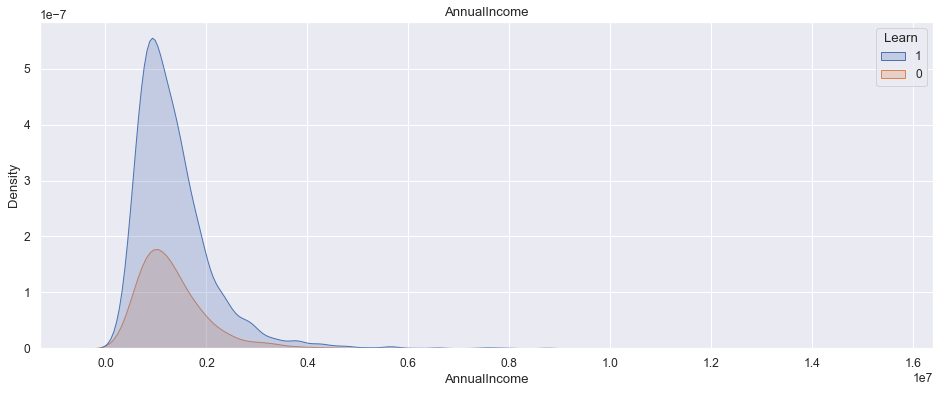

YearsInCurrentJob
MannwhitneyuResult(statistic=9325067.5, pvalue=0.34220972233907765)


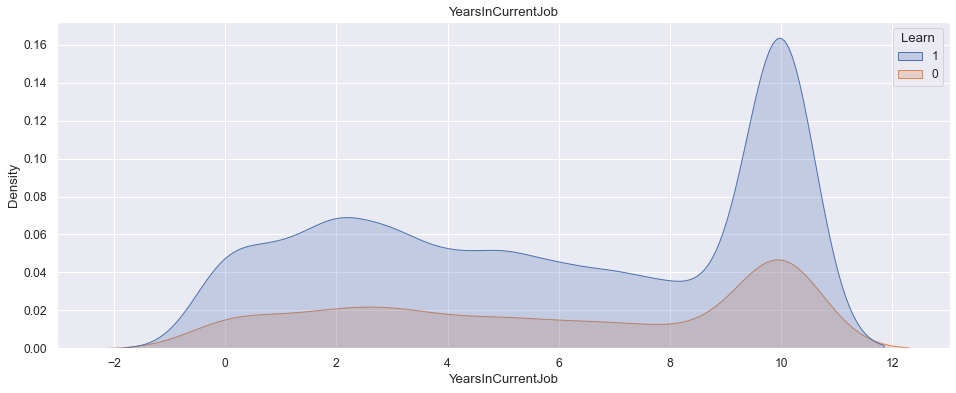

TaxLiens
MannwhitneyuResult(statistic=9336939.0, pvalue=0.09837742371078895)


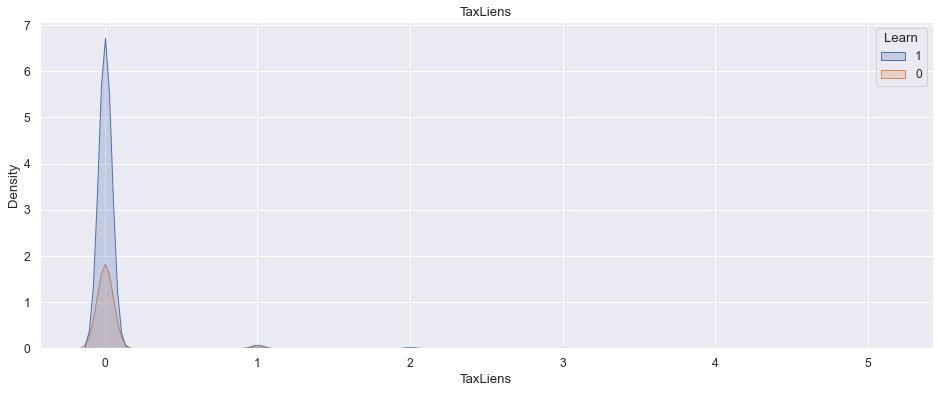

NumberOfOpenAccounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


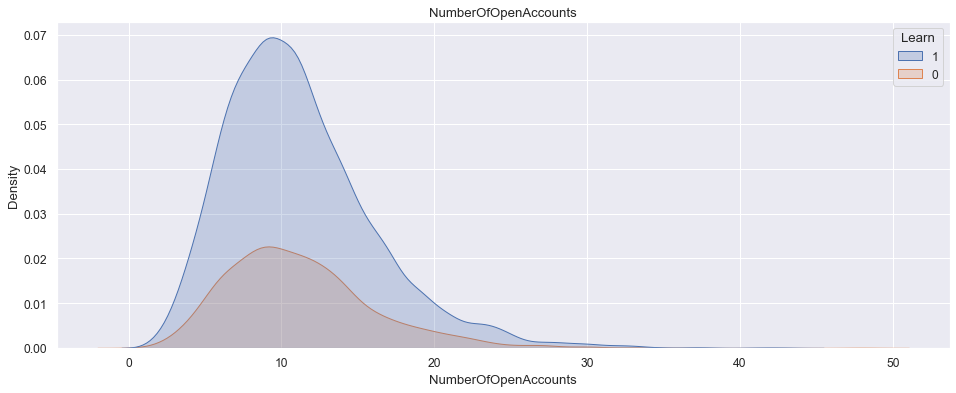

YearsOfCreditHistory
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


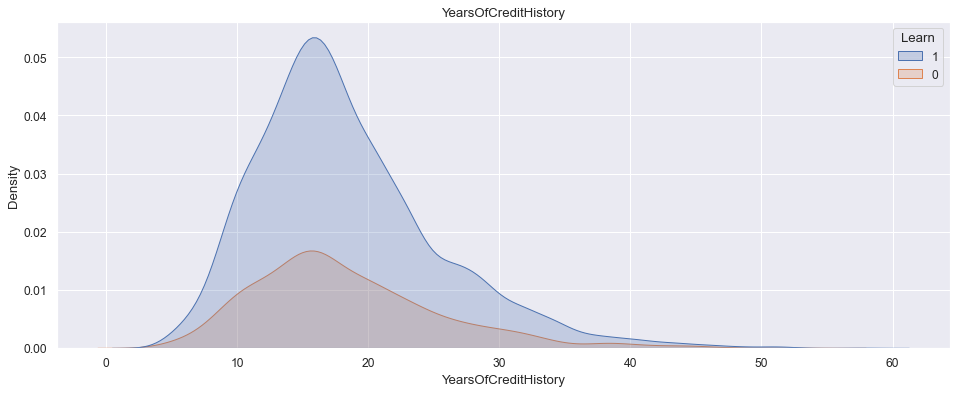

MaximumOpenCredit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


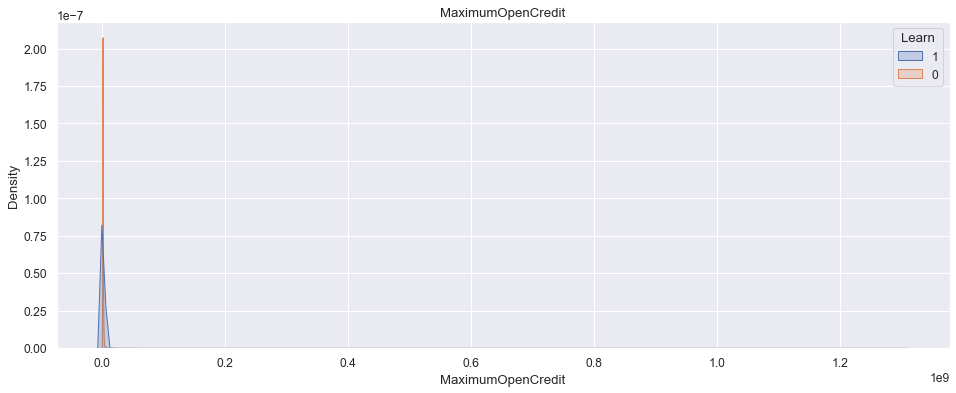

NumberOfCreditProblems
MannwhitneyuResult(statistic=9295491.0, pvalue=0.14188957757155873)


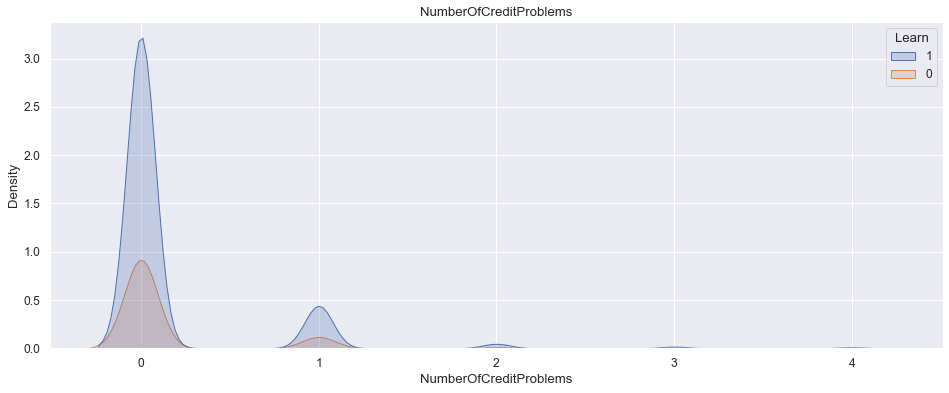

MonthsSinceLastDelinquent
MannwhitneyuResult(statistic=9346198.5, pvalue=0.40057108736095315)


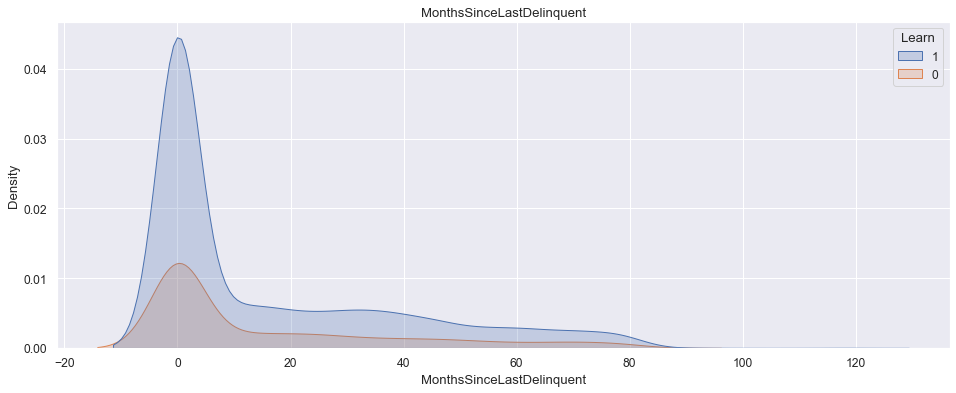

Bankruptcies
MannwhitneyuResult(statistic=9260973.0, pvalue=0.04432950519761078)


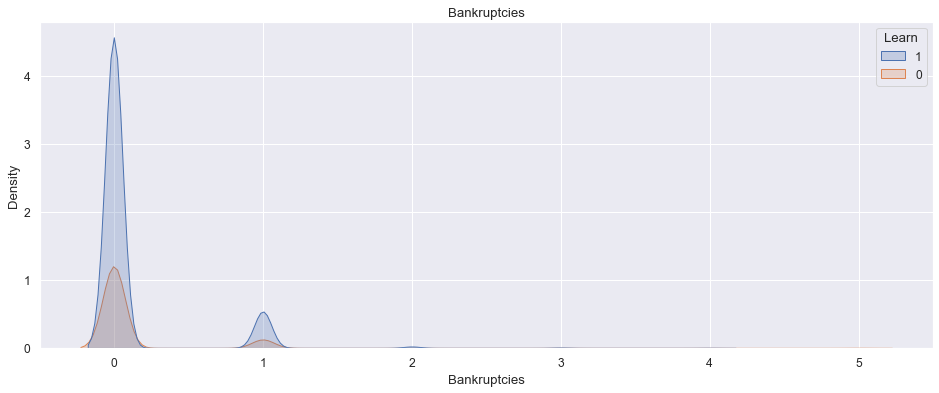

CurrentLoanAmount
MannwhitneyuResult(statistic=9203157.5, pvalue=0.08461730939896328)


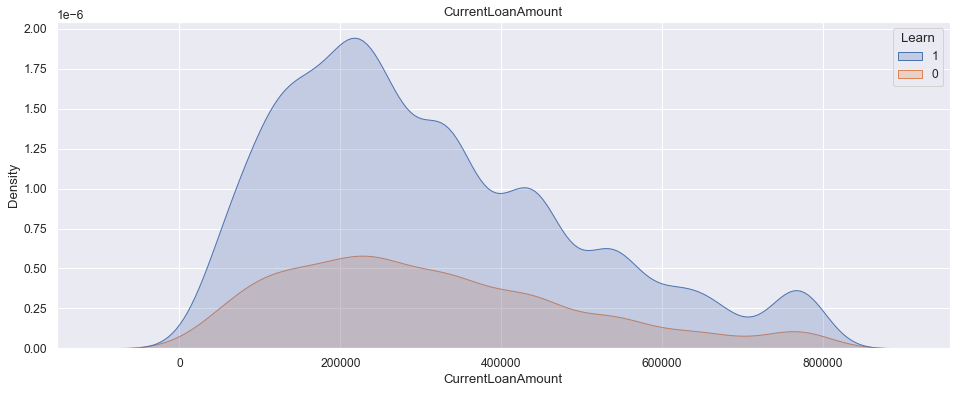

CurrentCreditBalance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


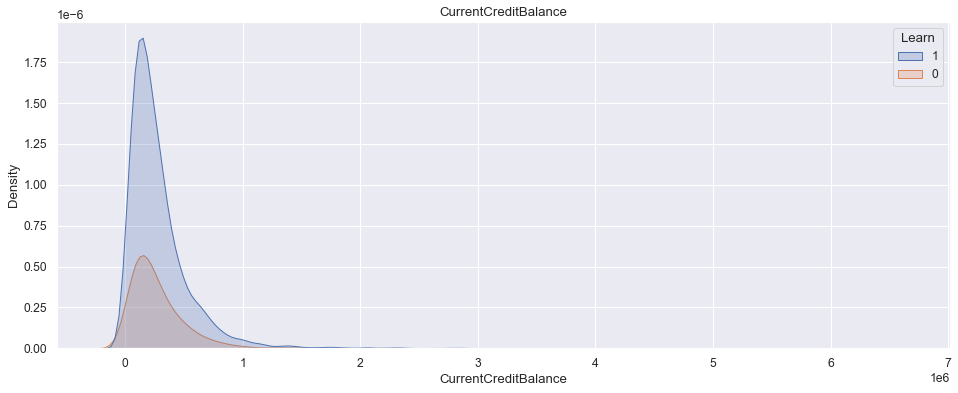

MonthlyDebt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


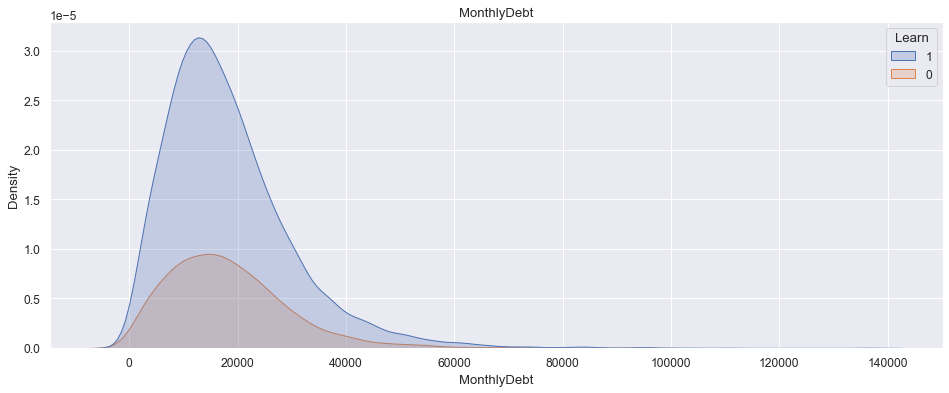

CreditScore
MannwhitneyuResult(statistic=9265042.0, pvalue=0.1895145850549937)


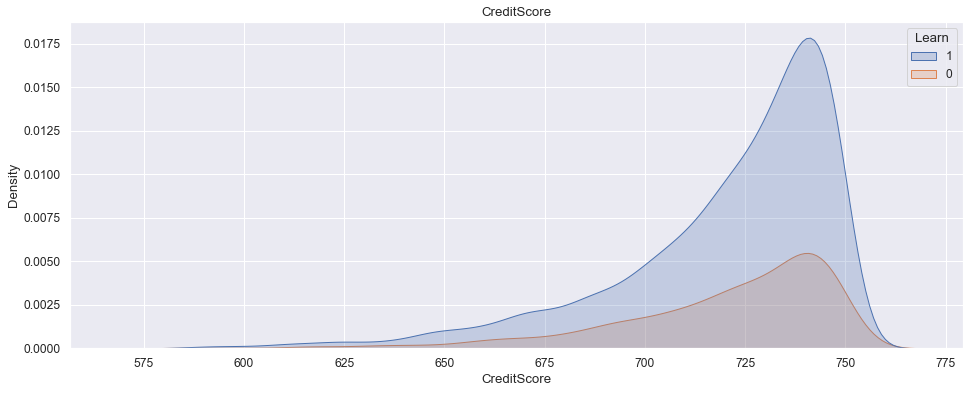

In [27]:
NUM_FEATURE_NAMES = dataset.select_dtypes(include='float64').columns.values.tolist()
NUM_FEATURE_NAMES.remove('CreditDefault')
for col in NUM_FEATURE_NAMES:
    sns.set(font_scale=1.1)
    plt.figure(figsize=(16, 6))
    sns.kdeplot(data=dataset, x=col, shade=True, hue='Learn', hue_order=[1, 0])
    print(col)
    print(mannwhitneyu(dataset[dataset.Learn == 1][col], dataset[dataset.Learn == 0][col]))
    plt.title(col)
    plt.show()

Подозрительная разница в распределениях признака Bankruptcies чуть ниже 5%, оставляем его.

**Проверим распределения категориальных признаков на трейне и тесте**

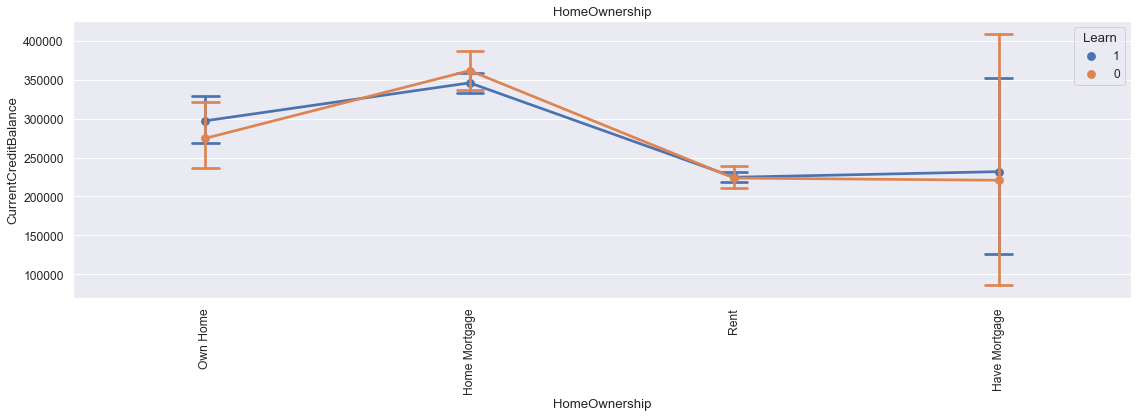

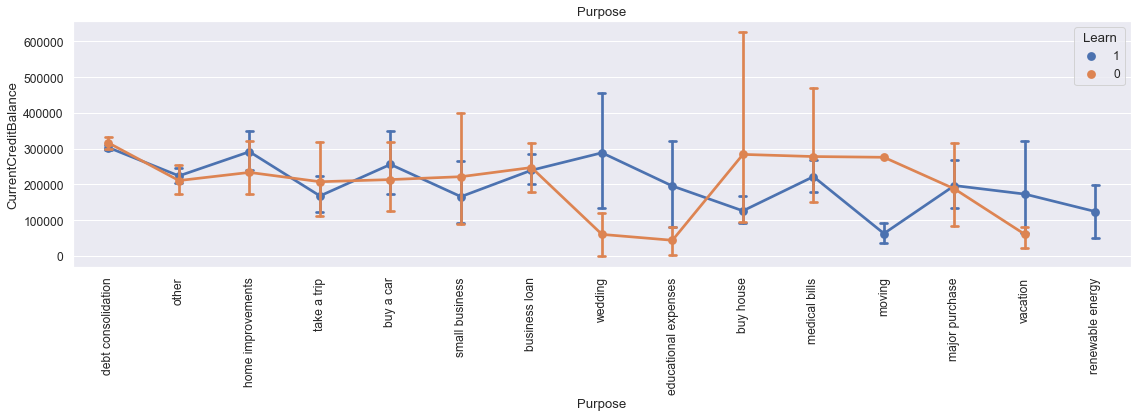

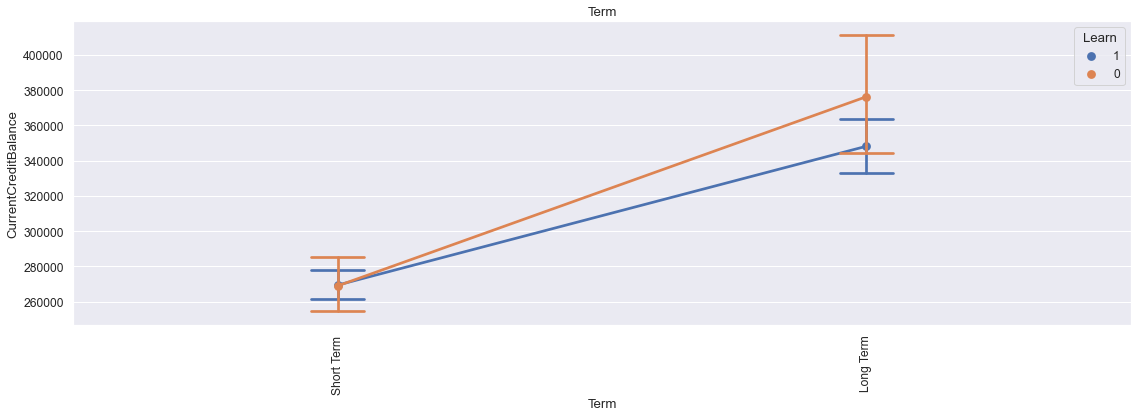

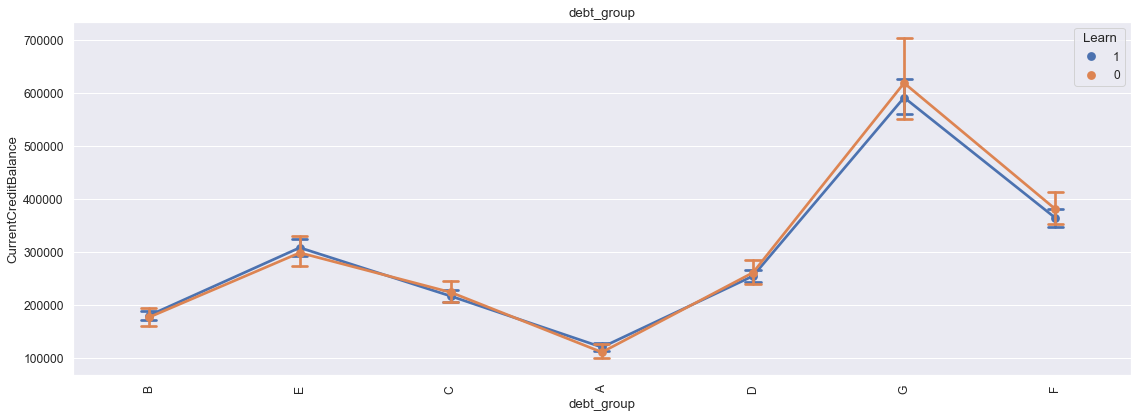

In [28]:
CAT_FEATURE_NAMES = dataset.select_dtypes(include='object').columns.values.tolist()
num_feature = 'CurrentCreditBalance'
for col in CAT_FEATURE_NAMES:
    sns.set(font_scale=1.1)
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.pointplot(data=dataset, x=col, y=num_feature, capsize=.1, shade=True, hue='Learn', hue_order=[1, 0])
    plt.title(col)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.show()

Подозрительное распределение в признака Purpose для значений: wedding, educational expenses, moving и vacation. Значения renewable energy на тесте вообще нет. Т.к. этих значений мало, возможно нужно укрупнить группы.

Посмотрим на значения признаков по группировкам.

In [29]:
df_cat = dataset[dataset.Learn == 1].groupby('Purpose', as_index=False).mean()
df_cat

Purpose  AnnualIncome  YearsInCurrentJob  TaxLiens  \
0          business loan  1.578203e+06           4.968254  0.069767   
1              buy a car  1.271642e+06           4.612903  0.031250   
2              buy house  1.757871e+06           5.781250  0.058824   
3     debt consolidation  1.346966e+06           5.947443  0.027591   
4   educational expenses  1.179417e+06           3.000000  0.000000   
5      home improvements  1.640379e+06           6.358639  0.026699   
6         major purchase  1.347141e+06           4.631579  0.100000   
7          medical bills  1.601686e+06           6.188406  0.084507   
8                 moving  1.012979e+06           3.545455  0.000000   
9                  other  1.306160e+06           5.544715  0.034586   
10      renewable energy           NaN           6.500000  0.000000   
11        small business  1.326634e+06           5.640000  0.000000   
12           take a trip  1.153258e+06           5.571429  0.000000   
13              vacation  1.578060e+06           3.375000  0.000000   
14               wedding  2.095394e+06           5.200000  0.000000   

    NumberOfOpenAccounts  YearsOfCreditHistory  MaximumOpenCredit  \
0               9.930233             17.293798       6.904260e+05   
1               9.927083             17.063542       8.521640e+05   
2               9.794118             17.679412       4.653155e+05   
3              11.335464             18.297645       8.858158e+05   
4              13.700000             24.610000       4.919046e+05   
5              11.041262             19.516990       1.052217e+06   
6              11.075000             16.822500       5.161629e+05   
7              10.450704             20.059155       5.070926e+05   
8               9.818182             16.127273       2.960020e+05   
9              10.033083             18.139549       1.087534e+06   
10              8.500000             25.250000       2.386560e+05   
11             11.307692             18.373077       3.838442e+05   
12              8.648649             16.145946       1.060097e+07   
13             13.500000             17.712500       3.665502e+05   
14              9.800000             17.200000       6.331219e+05   

    NumberOfCreditProblems  MonthsSinceLastDelinquent  Bankruptcies  \
0                 0.139535                  12.860465      0.038760   
1                 0.135417                  14.458333      0.093750   
2                 0.176471                  19.176471      0.088235   
3                 0.166050                  15.803163      0.118607   
4                 0.000000                  12.400000      0.000000   
5                 0.213592                  16.798544      0.167476   
6                 0.175000                  13.700000      0.125000   
7                 0.169014                  18.971831      0.098592   
8                 0.181818                  14.454545      0.181818   
9                 0.163910                  15.482707      0.100752   
10                0.000000                  12.500000      0.000000   
11                0.000000                  17.038462      0.000000   
12                0.189189                  16.918919      0.108108   
13                0.875000                  32.875000      0.125000   
14                0.066667                  15.266667      0.000000   

    CurrentLoanAmount  CurrentCreditBalance   MonthlyDebt  CreditScore  \
0       356779.220339         239638.604651  16371.627907   708.575472   
1       171090.117647         255920.104167  13691.250000   726.298701   
2       329001.851852         126031.470588  15158.441176   706.807692   
3       322849.230126         303211.336978  18797.475269   721.136364   
4       172885.428571         195447.300000  15022.900000   726.777778   
5       317223.845714         291482.689320  18373.279126   722.943038   
6       253011.891892         196830.500000  17702.275000   716.233333   
7       212688.666667         221769.873239  1

In [30]:
df_cat = dataset[dataset.Learn == 1].groupby('NumberOfCreditProblems', as_index=False).mean()
df_cat

NumberOfCreditProblems  AnnualIncome  YearsInCurrentJob  TaxLiens  \
0                     0.0  1.382793e+06           5.779194  0.000000   
1                     1.0  1.217429e+06           6.666250  0.063492   
2                     2.0  1.581603e+06           5.915663  0.666667   
3                     3.0  1.058281e+06           6.071429  1.400000   
4                     4.0  1.976651e+06           5.333333  2.619048   

   NumberOfOpenAccounts  YearsOfCreditHistory  MaximumOpenCredit  \
0             11.159221             18.078992      970867.349204   
1             11.009070             19.844785      841474.208617   
2             10.741935             19.679570      439423.505376   
3             10.514286             19.002857      418930.285714   
4             10.285714             20.457143      495375.047619   

   MonthsSinceLastDelinquent  Bankruptcies  CurrentLoanAmount  \
0                  14.996290      0.000000      315674.505248   
1                  19.708617      0.836735      264136.898327   
2                  26.000000      0.892473      284947.540230   
3                  27.085714      1.114286      245011.800000   
4                  40.666667      0.809524      353053.800000   

   CurrentCreditBalance   MonthlyDebt  CreditScore  CreditDefault  Learn  
0         308800.168341  18624.986860   720.658670       0.280569      1  
1         167910.302721  16136.947846   717.113506       0.273243      1  
2         195239.913978  17586.612903   713.425000       0.354839      1  
3         173489.542857  15791.257143   718.166667       0.400000      1  
4         180697.238095  21539.476190   702.437500       0.476190      1

In [31]:
df_cat = dataset[dataset.Learn == 1].groupby(['Purpose', 'NumberOfCreditProblems'], as_index=False).mean()
df_cat.head(20)

Purpose  NumberOfCreditProblems  AnnualIncome  \
0          business loan                     0.0  1.597637e+06   
1          business loan                     1.0  1.216809e+06   
2          business loan                     3.0           NaN   
3          business loan                     4.0  1.900542e+06   
4              buy a car                     0.0  1.307536e+06   
5              buy a car                     1.0  1.065866e+06   
6              buy a car                     2.0  7.186940e+05   
7              buy house                     0.0  1.790686e+06   
8              buy house                     1.0  1.660163e+06   
9              buy house                     2.0  1.329069e+06   
10    debt consolidation                     0.0  1.362176e+06   
11    debt consolidation                     1.0  1.204568e+06   
12    debt consolidation                     2.0  1.607557e+06   
13    debt consolidation                     3.0  1.125793e+06   
14    debt consolidation                     4.0  1.873022e+06   
15  educational expenses                     0.0  1.179417e+06   
16     home improvements                     0.0  1.695897e+06   
17     home improvements                     1.0  1.436390e+06   
18     home improvements                     2.0  1.262124e+06   
19     home improvements                     3.0  7.721410e+05   

    YearsInCurrentJob  TaxLiens  NumberOfOpenAccounts  YearsOfCreditHistory  \
0            4.888889  0.000000              9.857143             17.012605   
1            5.166667  0.142857             11.571429             23.428571   
2            3.000000  3.000000              7.000000              8.300000   
3           10.000000  2.500000             10.000000             17.050000   
4            4.280488  0.000000             10.095238             17.103571   
5            7.200000  0.181818              8.727273             16.454545   
6            6.000000  1.000000              9.000000             20.400000   
7            5.851852  0.000000              9.517241             16.989655   
8            5.750000  0.250000             11.500000             20.200000   
9            4.000000  1.000000             11.000000             27.600000   
10           5.854509  0.000000             11.370197             18.060581   
11           6.669291  0.058405             11.176638             19.839744   
12           6.153846  0.698630             10.657534             19.097260   
13           6.120000  1.379310             11.275862             19.844828   
14           4.200000  2.461538             10.153846             20.576923   
15           3.000000  0.000000             13.700000             24.610000   
16           6.287540  0.000000             11.143284             19.548657   
17           6.916667  0.074627             10.567164             19.182090   
18           5.250000  0.444444             11.222222             21.266667   
19           4.000000  2.000000              7.000000             15.600000   

    MaximumOpenCredit  MonthsSinceLastDelinquent  Bankruptcies  \
0        7.147451e+05                  12.243697      0.000000   
1        4.293803e+05                  20.857143      0.571429   
2        5.977400e+04                   0.000000      0.000000   
3        4.724280e+05                  28.000000      0.500000   
4        9.142467e+05                  15.011905      0.000000   
5        4.235040e+05                  11.545455      0.727273   
6        3.524840e+05                   0.000000      1.000000   
7        4.668309e+05                  19.344828      0.000000   
8        4.801170e+05                  18.500000      0.750000   
9        3.621640e+05                  17.000000      0.000000   
10       9.585922e+05                  15.054808      0.000000   
11       4.249223e+05                  19.337607      0.849003   
12       4.344331e+05                  24.794521      0.849315   
13       4.588821e+05                  29.9310

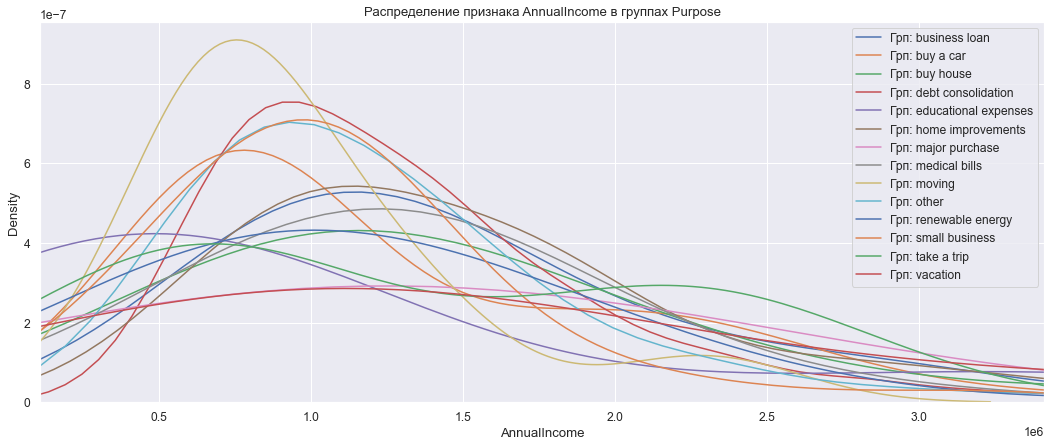

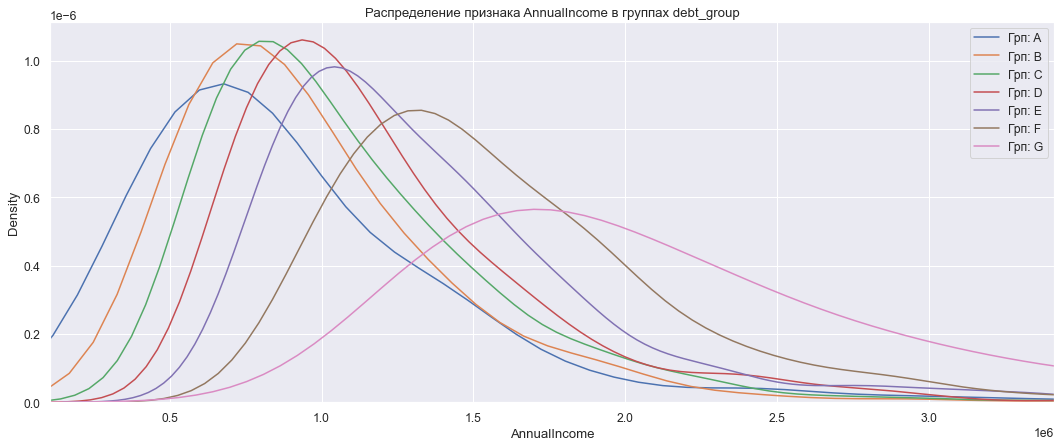

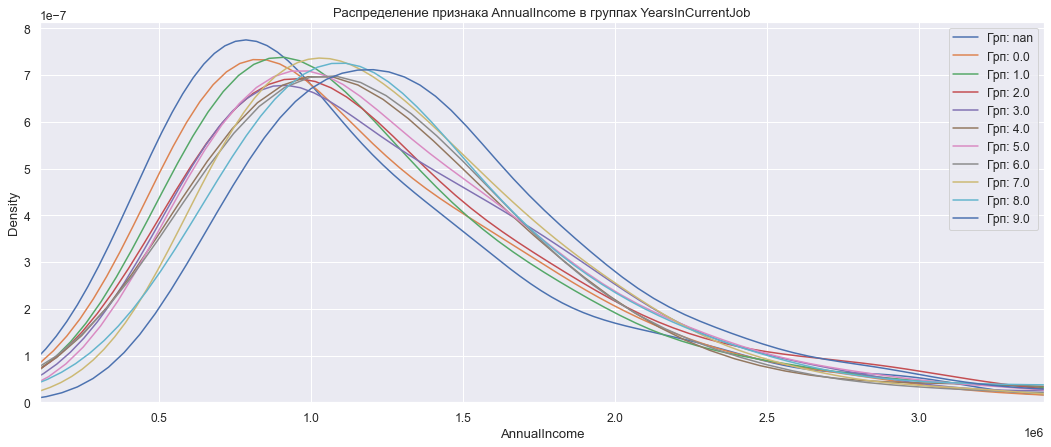

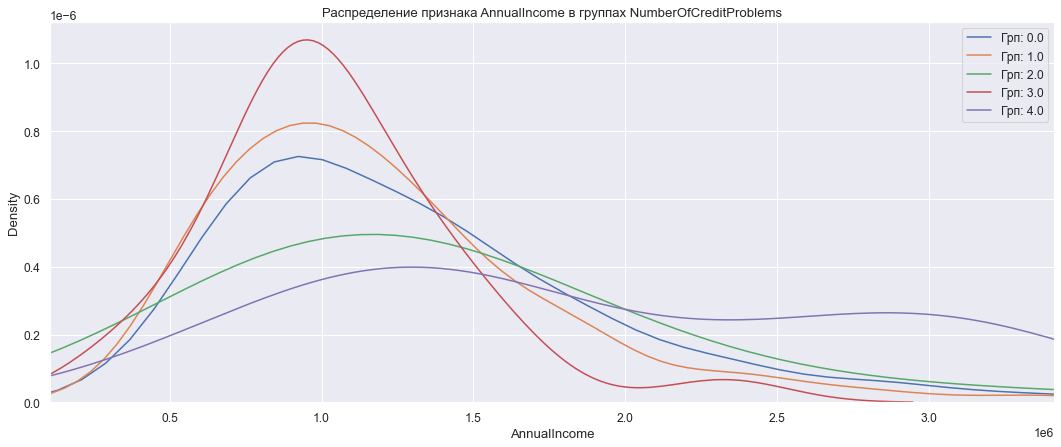

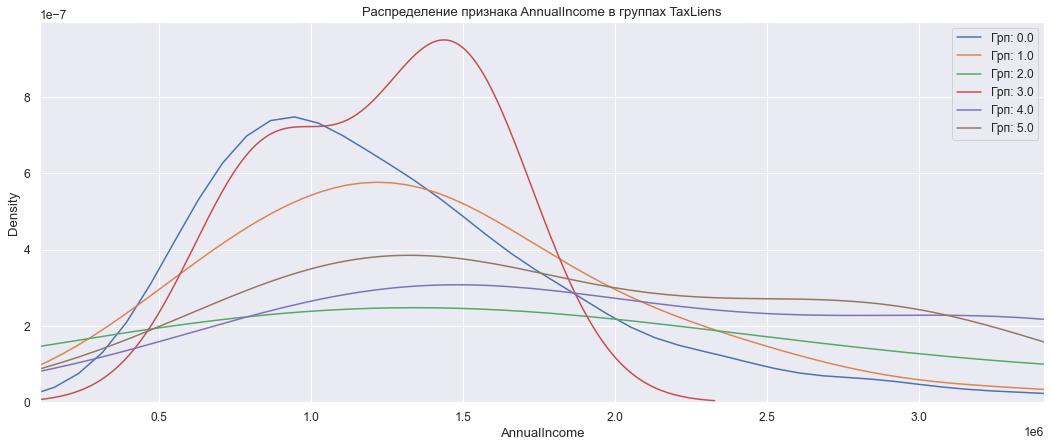

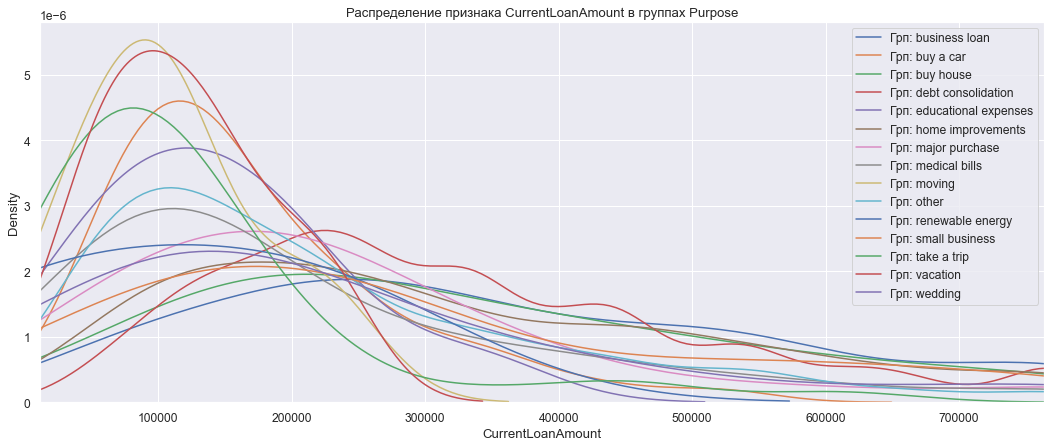

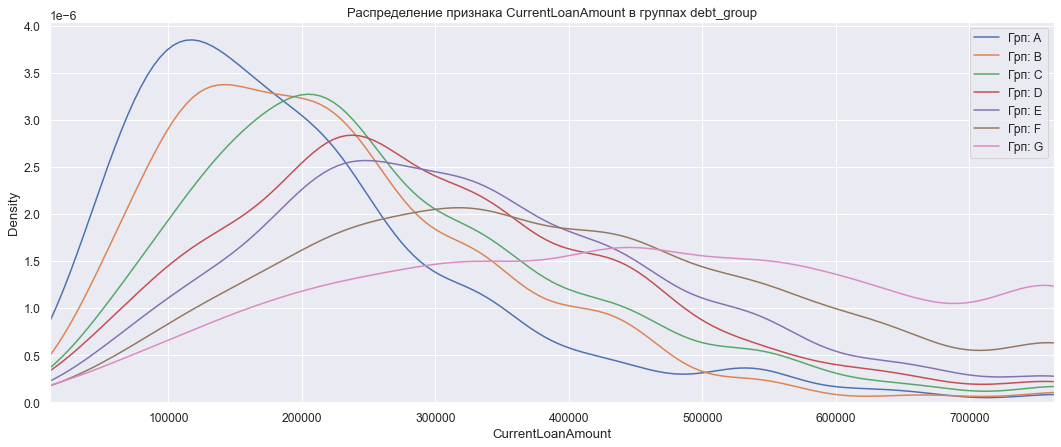

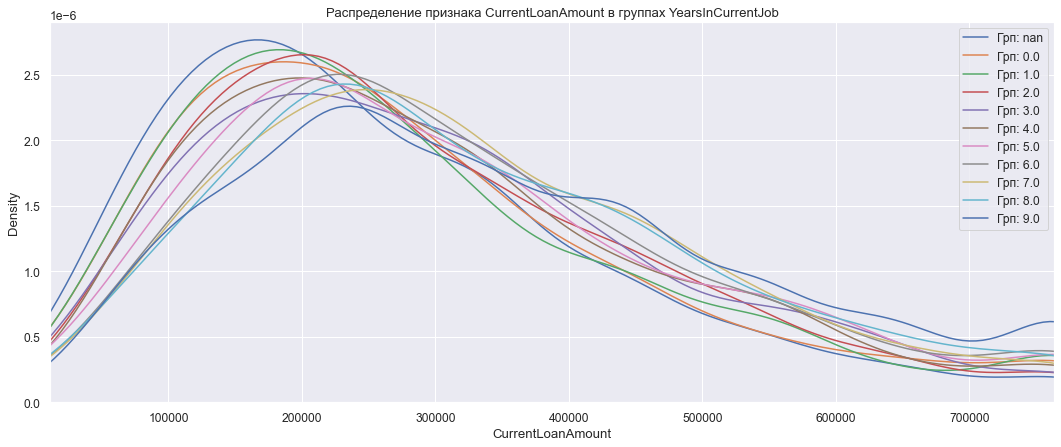

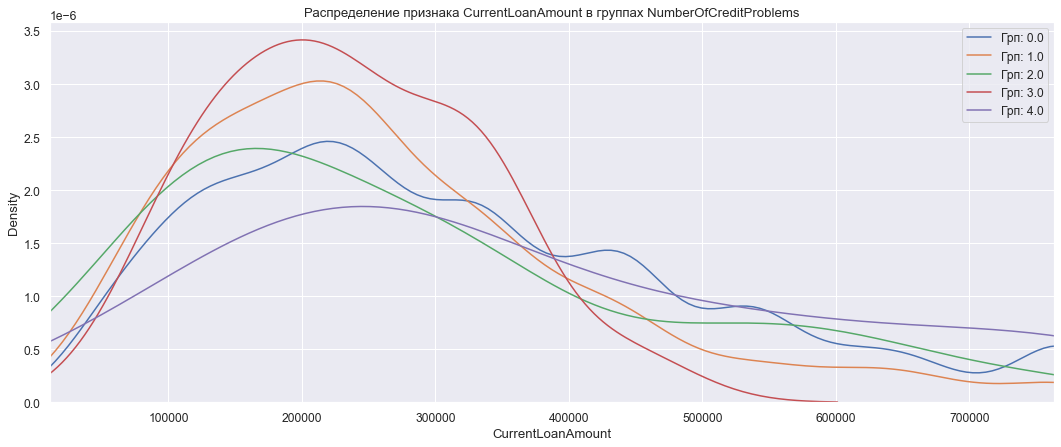

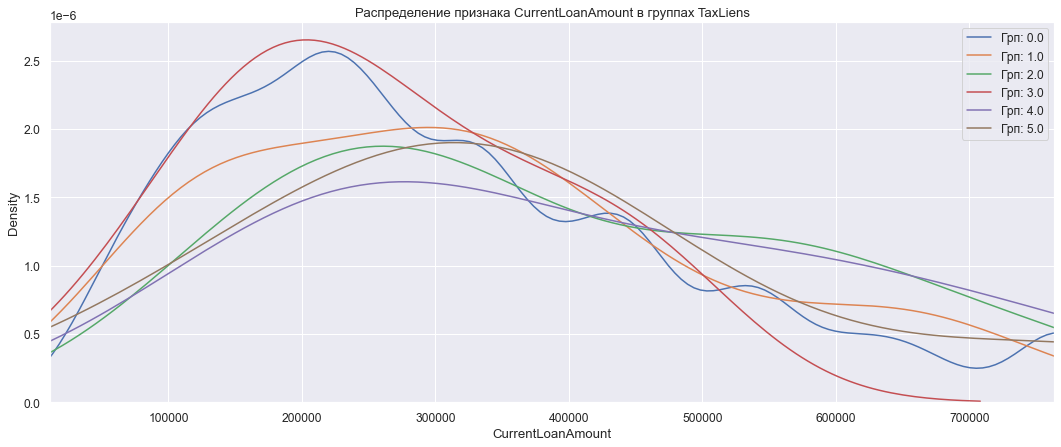

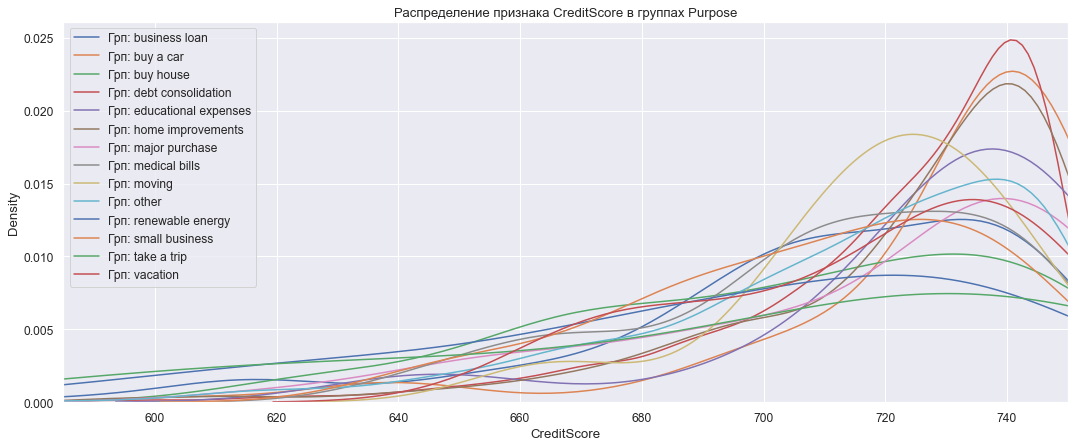

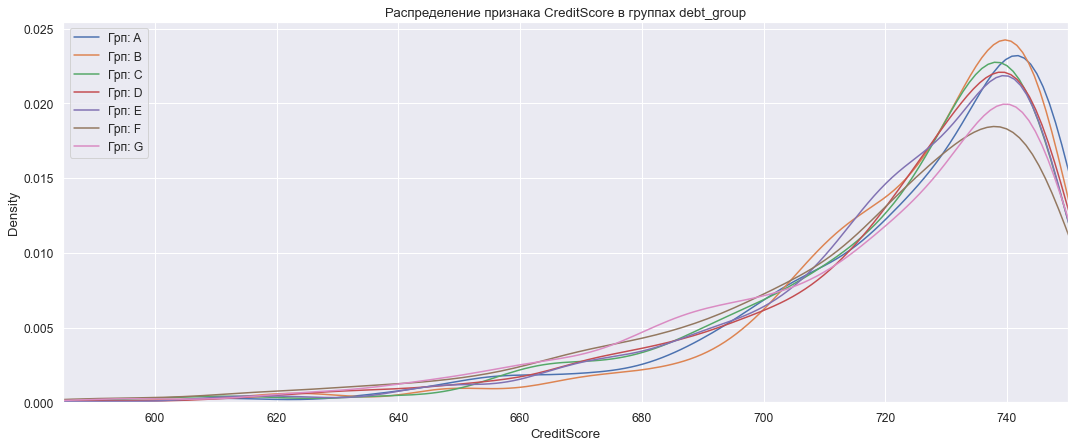

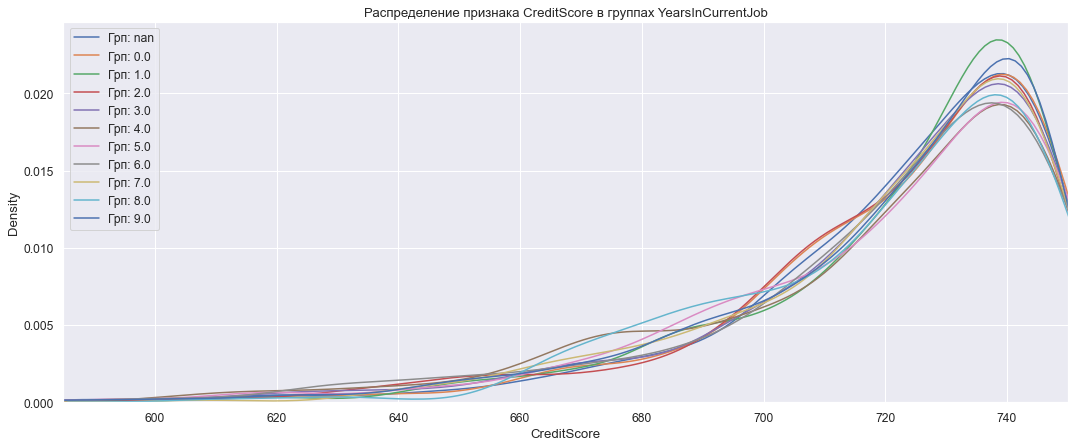

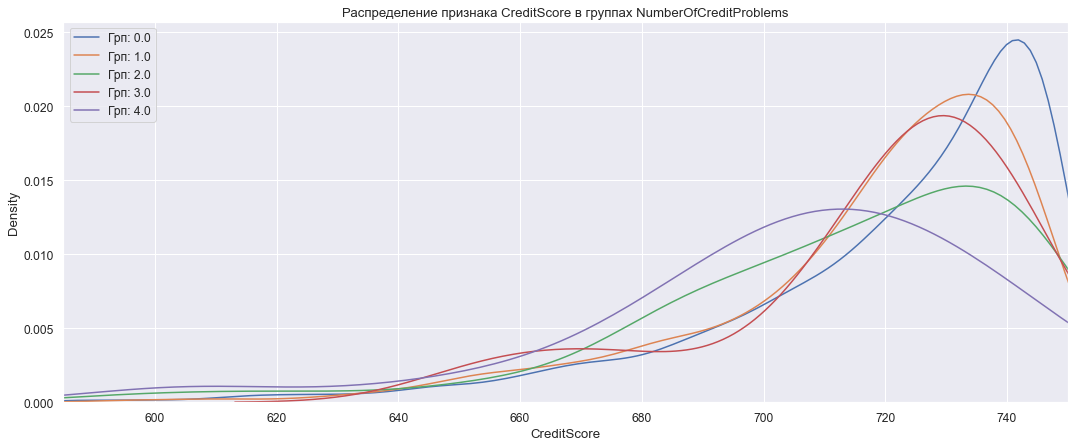

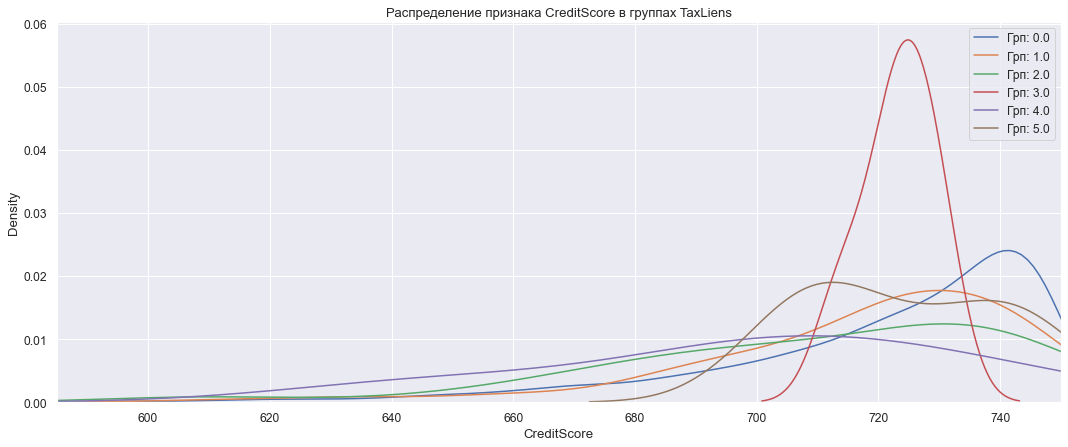

In [32]:
# Посмотрим влияние группировок на признаки с пропусками и выбросами
for feature in ('AnnualIncome', 'CurrentLoanAmount', 'CreditScore'):
    for group in ('Purpose', 'debt_group', 'YearsInCurrentJob', 'NumberOfCreditProblems', 'TaxLiens'):
        show_plot_feature(feature, group)

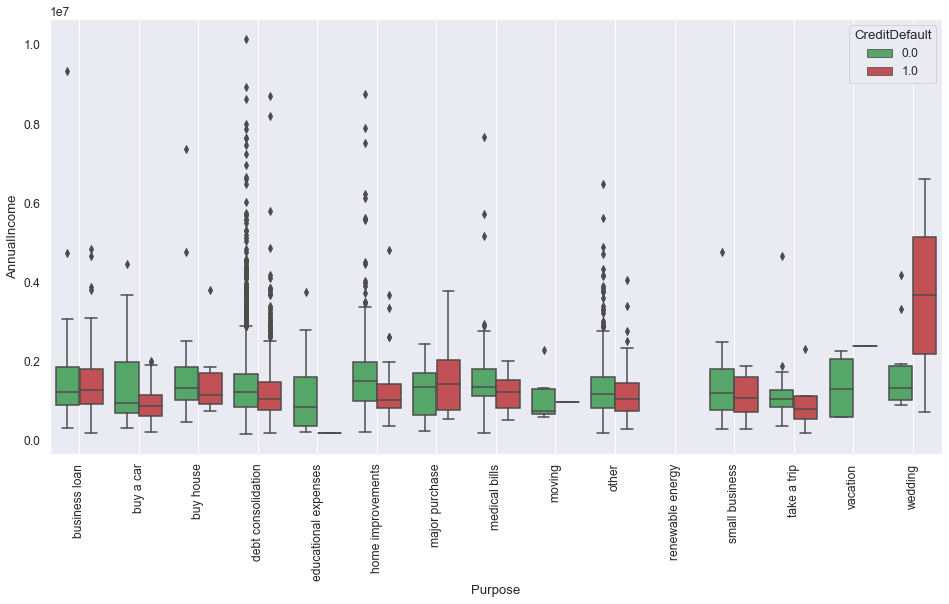

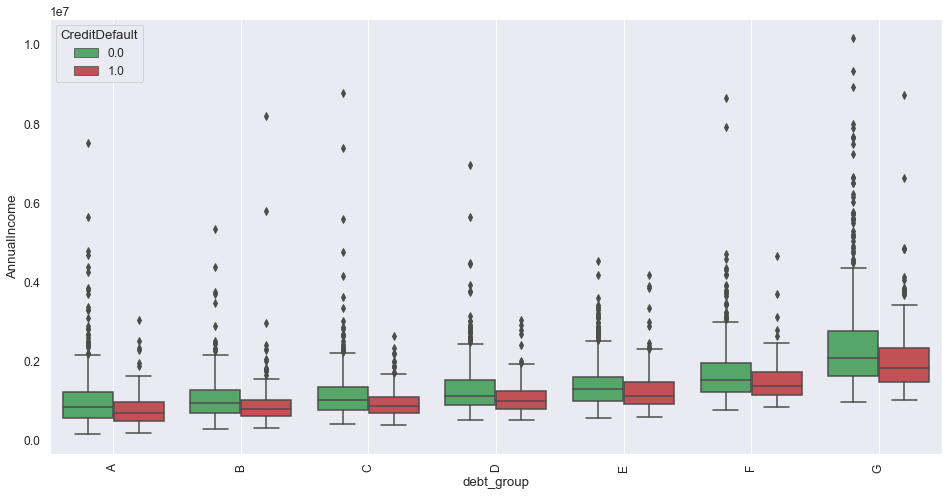

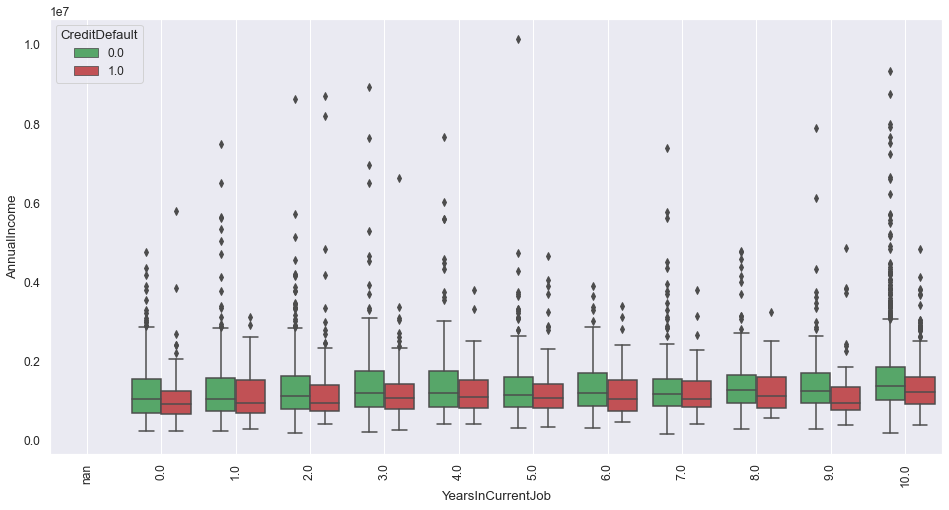

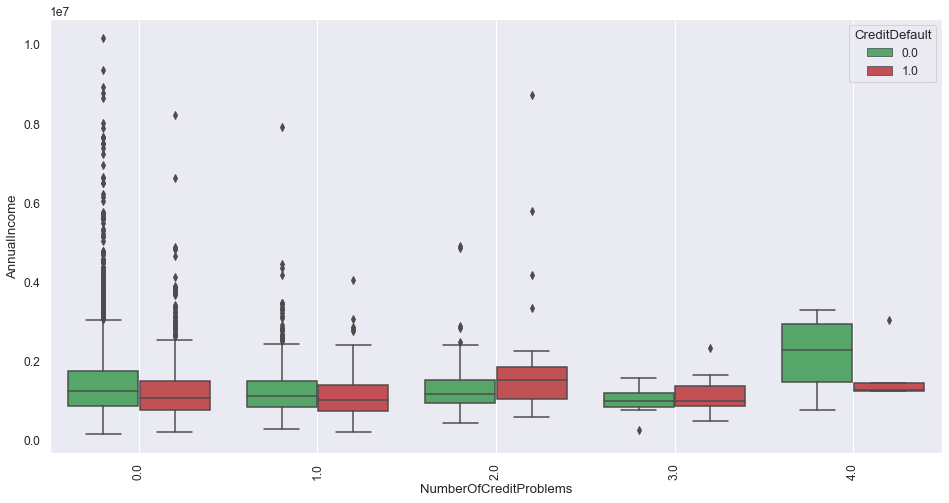

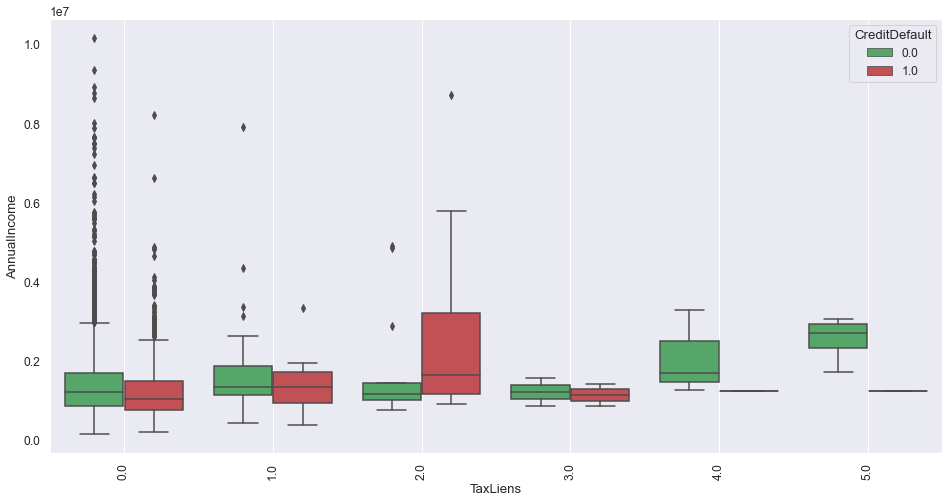

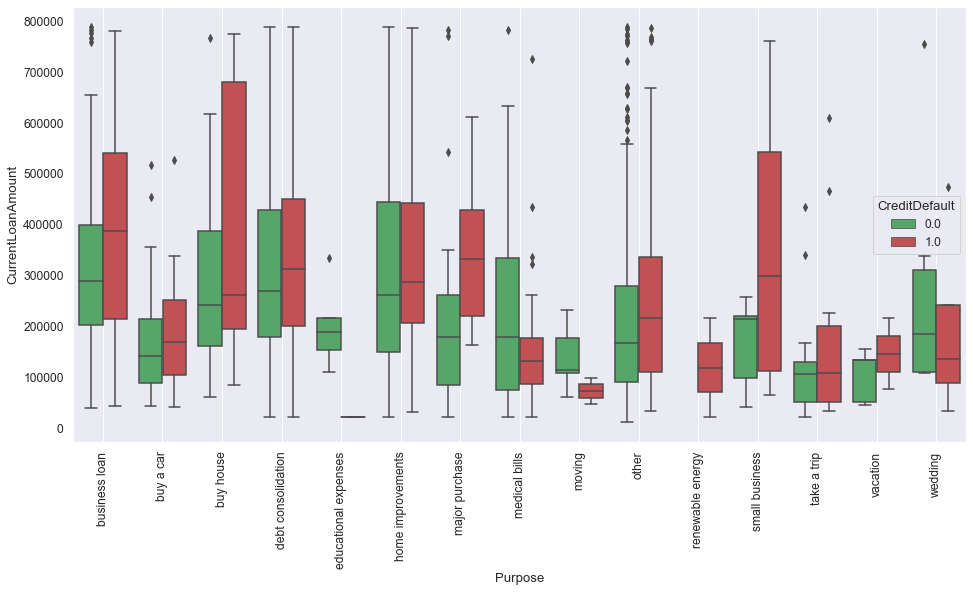

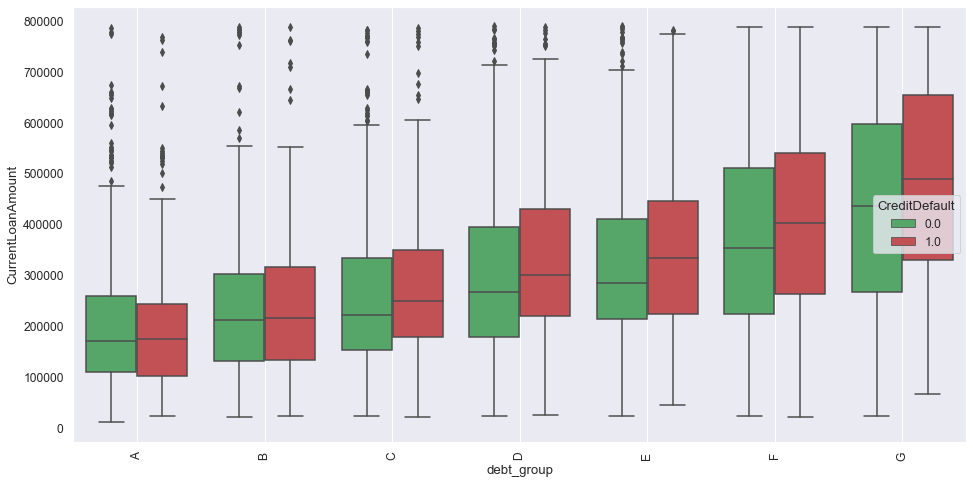

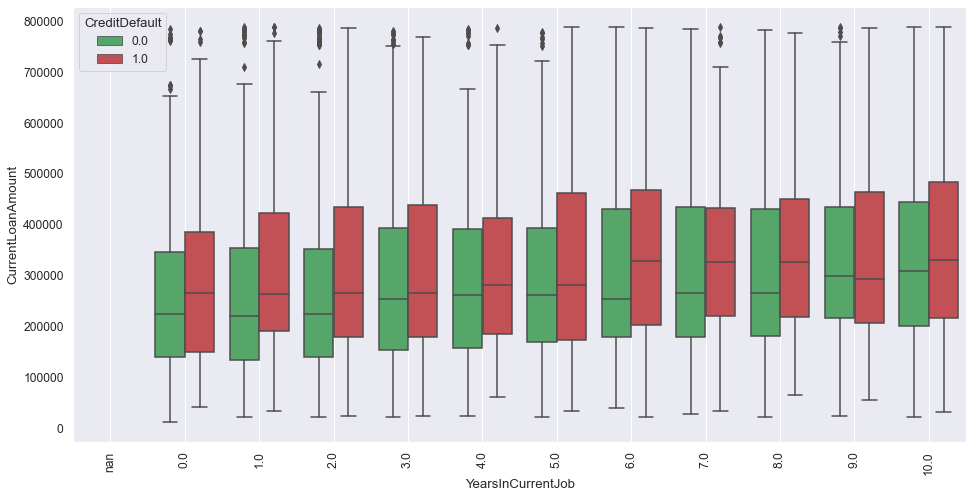

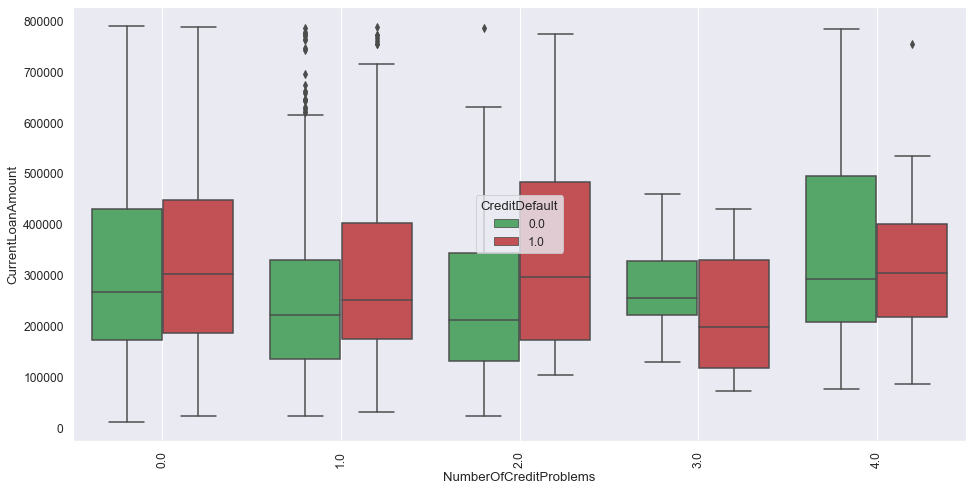

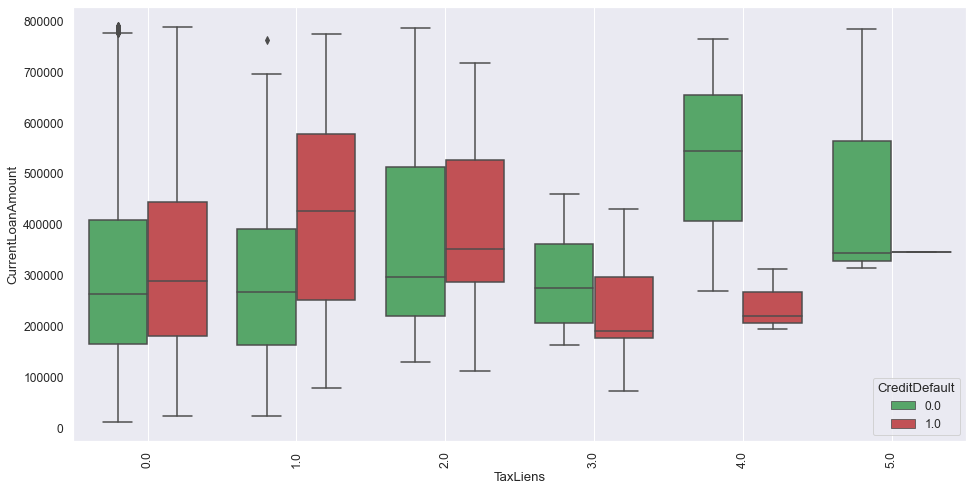

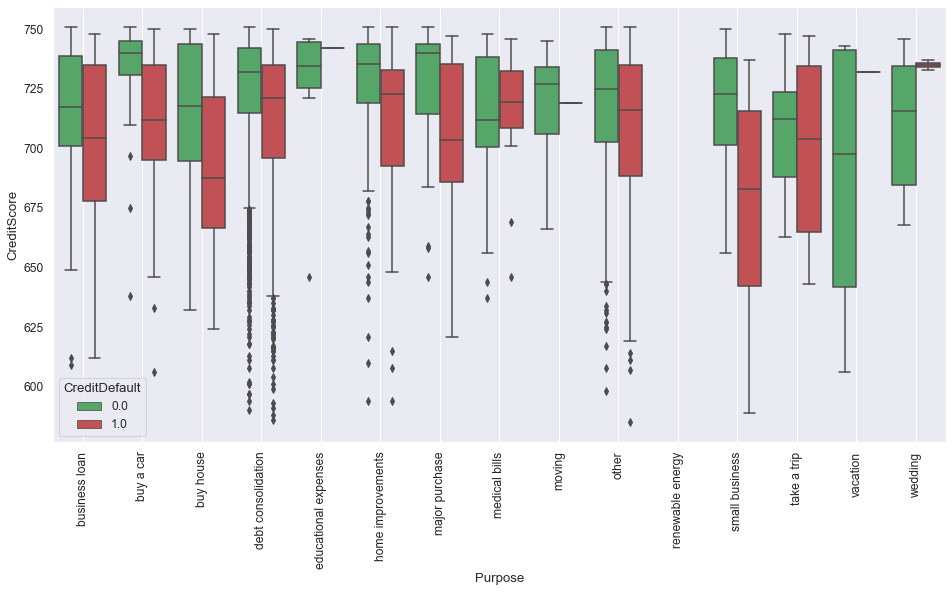

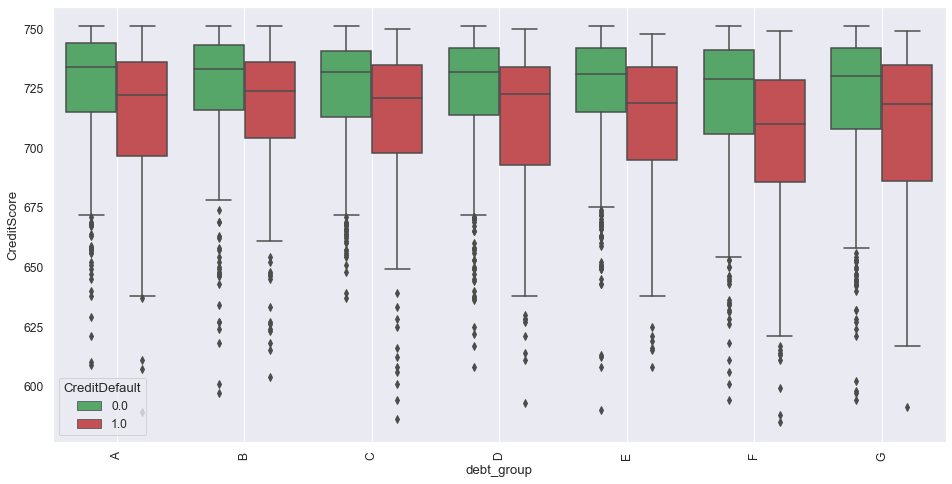

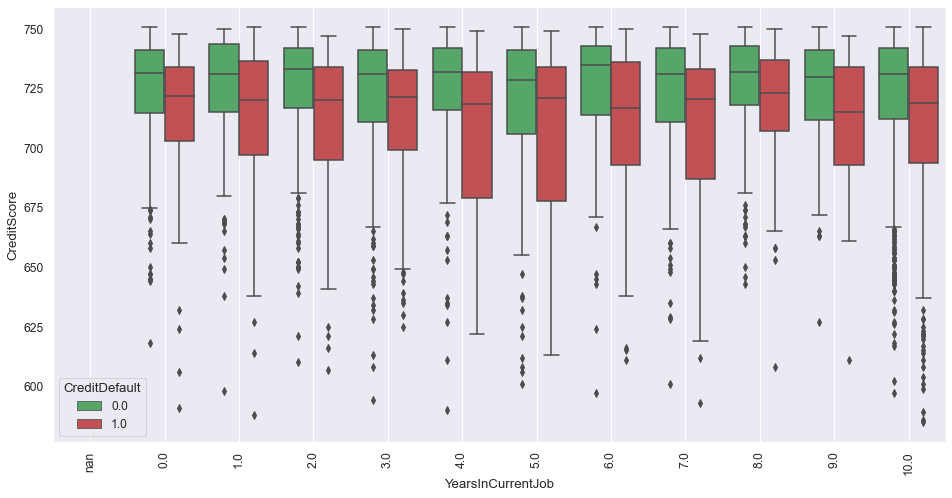

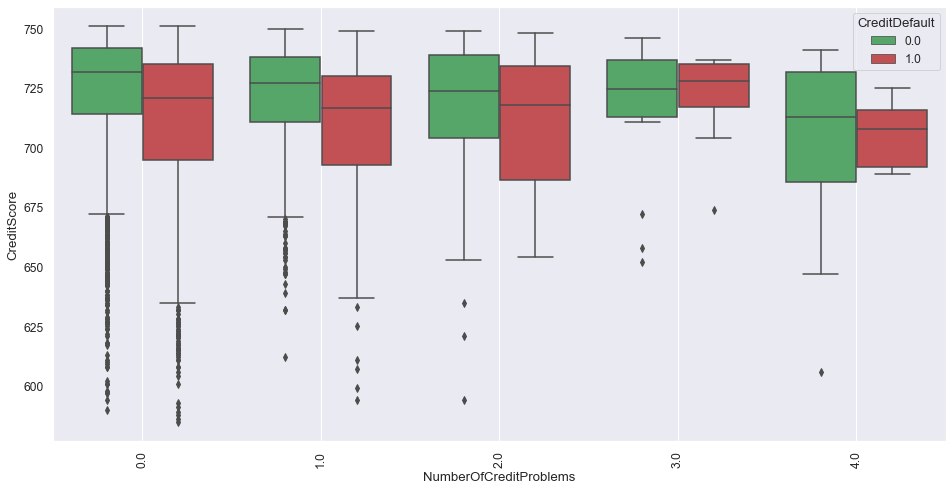

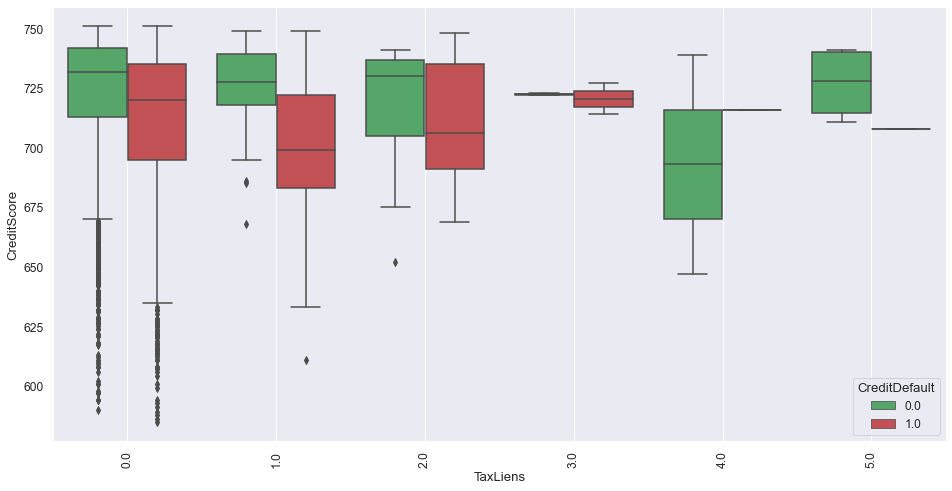

In [33]:
# Посмотрим влияние группировок на признаки с пропусками и выбросами в другом виде
for feature in ('AnnualIncome', 'CurrentLoanAmount', 'CreditScore'):
    for group in ('Purpose', 'debt_group', 'YearsInCurrentJob', 'NumberOfCreditProblems', 'TaxLiens'):
        fig, ax = plt.subplots(figsize=(16, 8))
        sns.boxplot(x=group, y=feature, hue='CreditDefault', order=sorted(dataset[group].unique()), 
                    palette=['g', 'r'], saturation=.95, data=dataset[dataset.Learn == 1])
        ax.grid()
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()

# Завернем всё в функции и классы и обучаем первую модель.

In [34]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score as r2
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering

import featuretools as ft
import featuretools.variable_types as vtypes
from itertools import combinations

In [35]:
def process_model(use_model=CatBoostClassifier(random_state=SEED),
                  params={'max_depth': [5]}, folds_range=[], fold_single=5,
                  verbose=0, build_model=False):
    """
    Поиск лучшей модели
    :param use_model: модель для обучения и предсказаний
    :param params: параметры для модели
    :param folds_range: диапазон фолдов на сколько разбивать обучающие данные
    :param fold_single: на сколько фолдов разбивать данные финальной модели
    :param verbose: = 1 - отображать процесс
    :param build_model: = True - строить модель и выгружать предсказания
    :return: параметры модели, feat_imp_df - датафрейм с фичами
    """

    def iter_folds(n_fold, verb=0, cat=''):
        """
        Итерация для поиска лучшей модели для заданного количества флодов
        :param n_fold: количество фолдов
        :param verb: = 1 - отображать процесс
        :param cat: True - обучаем catBoost
        :return: f1_score_train, f1_score_valid, модель
        """
        skf = StratifiedKFold(n_splits=n_fold, random_state=SEED, shuffle=True)
        if cat == 'cb_':
            gscv = use_model.grid_search(params, X_train, y_train, cv=skf,
                                         stratified=True, plot=True, refit=True)
            use_model.fit(X_train, y_train)
            y_train_pred = use_model.predict(X_train)
            y_valid_pred = use_model.predict(X_valid)
            best_ = gscv['params']
            gscv = use_model
        else:
            gscv = GridSearchCV(use_model, params, cv=skf, scoring='f1',
                                verbose=verb, n_jobs=USE_CORES)
            gscv.fit(X_train, y_train)
            best_ = gscv.best_params_
            best_tree_cv = gscv.best_estimator_
            y_train_pred = best_tree_cv.predict(X_train)
            y_valid_pred = best_tree_cv.predict(X_valid)
        f1_train = f1_score(y_train, y_train_pred)
        f1_valid = f1_score(y_valid, y_valid_pred)
        print(f'folds={n_fold:2d}, f1_score_train={f1_train:0.7f},'
              f' f1_score_valid={f1_valid:0.7f}'
              f' best_params={best_}')
        return f1_train, f1_valid, best_, gscv, y_train_pred, y_valid_pred

    submit_prefix = ''
    prefixes = {'import RandomForestClassifier': 'rf_',
                'import ExtraTreesClassifier': 'et_',
                'import GradientBoostingClassifier': 'gb_',
                'LightGBM classifier': 'lg_',
                'None': 'cb_'}
    for model_name, prefix in prefixes.items():
        if model_name in str(use_model.__doc__):
            submit_prefix = prefix
            break
    file_submit_csv = os.path.join(PATH_EXPORT, f'{submit_prefix}submit.csv')
    if folds_range:
        print('Поиск лучших параметров...')
    start_time_cv = time.time()
    best_folds = []
    for folds in folds_range:
        f1_trn, f1_vld, best_prms, search, _, _ = iter_folds(folds, verbose,
                                                             submit_prefix)
        best_folds.append([f1_trn, f1_vld, folds, best_prms, search])
    if folds_range:
        # печатаем модели в порядке убывания рейтинга
        best_folds.sort(key=lambda x: (-x[1], x[2]))
        print()
        fold_single = best_folds[0][2]
        time_stamp = datetime.now().strftime('%y-%m-%d %H:%M:%S')
        file_name = os.path.join(PATH_EXPORT, 'log_work.csv')
        with open(file_name, 'a') as log:
            for line in best_folds:
                print(line[:4])
                log.write(f'{time_stamp}, {line[:5]}\n')
            log.write('\n')
        print_time(start_time_cv)
    # построение лучшей модели
    if build_model:
        start_time_cv = time.time()
        print('Обучение модели...')
        f1_trn, f1_vld, prms, search, trn_p, vld_p = iter_folds(fold_single,
                                                                verbose,
                                                                submit_prefix)
        print(prms)
        print()
        evaluate_preds(final_model, X_train, X_valid, y_train, y_valid)
        print()
        if submit_prefix == 'cb_':
            max_depth = prms['depth']
        else:
            max_depth = search.best_params_['max_depth']

        feat_imp = search.feature_importances_
        feat_imp_df = pd.DataFrame({'features': X.columns.values,
                                    'importances': feat_imp})
        feat_imp_df.sort_values('importances', ascending=False, inplace=True)
        # предсказание
        search.fit(X, y)
        submit = pd.read_csv(FILE_SAMPLE, index_col='Id')
        submit['Credit Default'] = search.predict(test_df)
#         submit_proba = submit.copy(deep=True)
#         submit_proba['p_value'] = search.predict_proba(test_df)[:, 1]
#         submit_proba['new'] = submit_proba['p_value'].apply(
#             lambda x: 1 if x > 0.4996 else 0)
#         submit_proba['Credit Default'] = submit_proba['new']
#         submit_proba.drop(['p_value', 'new'], axis=1, inplace=True)
#         submit_proba.to_csv(file_submit_csv)
        date_now = datetime.now()
        time_stamp = date_now.strftime('%y%m%d%H%M%S')
        submit.to_csv(file_submit_csv.replace('.csv', f'_{time_stamp}.csv'))
        # сохранение результатов итерации в файл
        file_name = os.path.join(PATH_EXPORT, 'results.csv')
        if os.path.exists(file_name):
            file_df = pd.read_csv(file_name)
            file_df.time_stamp = pd.to_datetime(file_df.time_stamp,
                                                format='%y-%m-%d %H:%M:%S')
            file_df.time_stamp = file_df.time_stamp.dt.strftime(
                '%y-%m-%d %H:%M:%S')
            if 'delta' not in file_df.columns:
                file_df.insert(6, 'delta', 0)
            if 'comment' not in file_df.columns:
                file_df['comment'] = ''
            # удаление колонок после 'comment'
            list_columns = file_df.columns.to_list()
            file_df = file_df[list_columns[:list_columns.index('comment') + 1]]
        else:
            file_df = pd.DataFrame()
        time_stamp = date_now.strftime('%y-%m-%d %H:%M:%S')
        features_list = feat_imp_df.to_dict(orient='split')['data']
        temp_df = pd.DataFrame({'time_stamp': time_stamp,
                                'mdl': submit_prefix[:2].upper(),
                                'max_depth': max_depth,
                                'folds': fold_single,
                                'f1_train': f1_trn,
                                'f1_valid': f1_vld,
                                'delta': f1_trn - f1_vld,
                                'best_params': [prms],
                                'features': [features_list],
                                'column_dummies': [processor_data.dummy],
                                'model_columns': [model_columns],
                                'category_columns': [category_columns],
                                'learn_exclude': [learn_exclude],
                                'comment': [processor_data.comment]
                                })

        file_df = file_df.append(temp_df)
        file_df.f1_train = file_df.f1_train.round(7)
        file_df.f1_valid = file_df.f1_valid.round(7)
        file_df.delta = file_df.f1_train - file_df.f1_valid
        file_df.to_csv(file_name, index=False)
        file_df.name_export_to_excel = 'results'
        # экспорт в эксель
        export_to_excel(file_df)
        print_time(start_time_cv)
        return feat_imp_df
    else:
        return best_folds


def find_depth(use_model, max_depth_values=range(3, 11), not_sklearn=0,
               show_plot=True):
    print(use_model)
    # Подберем оптимальное значение глубины обучения дерева.
    scores = pd.DataFrame(columns=['max_depth', 'train_score', 'valid_score'])
    for max_depth in max_depth_values:
        print(f'max_depth = {max_depth}')
        if not_sklearn == 1:
            find_model = use_model(random_state=SEED, max_depth=max_depth,
                                   num_leaves=63)
        elif not_sklearn == 2:
            find_model = use_model(random_state=SEED, max_depth=max_depth,
                                   silent=True, early_stopping_rounds=20,
                                   cat_features=category_columns)
        else:
            find_model = use_model(random_state=SEED, max_depth=max_depth)

        find_model.fit(X_train, y_train)

        y_train_pred = find_model.predict(X_train)
        y_valid_pred = find_model.predict(X_valid)
        train_score = f1_score(y_train, y_train_pred)
        valid_score = f1_score(y_valid, y_valid_pred)

        print(f'\ttrain_score = {train_score:.7f}')
        print(f'\tvalid_score = {valid_score:.7f}\n')

        scores.loc[len(scores)] = [max_depth, train_score, valid_score]

    scores.max_depth = scores.max_depth.astype(int)
    scores_data = pd.melt(scores,
                          id_vars=['max_depth'],
                          value_vars=['train_score', 'valid_score'],
                          var_name='dataset_type',
                          value_name='score')
    if show_plot:
        # Визуализация
        plt.figure(figsize=(12, 7))
        sns.lineplot(x='max_depth', y='score', hue='dataset_type',
                     data=scores_data, markers=True)
        plt.show()
    print(scores.sort_values('valid_score', ascending=False))
    print()
    print('Наилучший результат с параметрами:')
    print(scores.loc[scores.valid_score.idxmax()])
    print()


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time.time() - time_start
    hrs = time_apply // 3600
    mns = time_apply % 3600
    sec = mns % 60
    print(f'Время обработки: {hrs:.0f} час {mns // 60:.0f} мин {sec:.1f} сек')


def evaluate_preds(mdl, x_train, x_valid, ytrain, yvalid):
    y_train_pred = mdl.predict(x_train)
    y_valid_pred = mdl.predict(x_valid)
    show_classification_report(ytrain, y_train_pred, yvalid, y_valid_pred)


def show_classification_report(y_train_true, y_train_pred, y_valid_true,
                               y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))


def show_corr_matrix(df):
    plt.figure(figsize=(18, 12))
    sns.set(font_scale=1.4)
    corr_matrix = dataset[df.Learn == 1].drop('Learn', axis=1).corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) < 0.2] = 0
    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
    plt.title('Корреляция признаков')
    plt.show()


def show_plot_feature(feature, hue_on):
    legends = []
    fig, ax = plt.subplots(figsize=(18, 7))
    for element in dataset[hue_on].unique():
        sns.kdeplot(dataset[(dataset[hue_on] == element)][feature], ax=ax)
        legends.append(f'Группа: {element}')
    ax.legend(legends)
    ax.set_xlim(dataset[feature].min(), dataset[feature].quantile(0.975))
    plt.title(f'Распределение признака {feature} в группах {hue_on}')
    plt.show()


def export_to_excel(data: pd.DataFrame) -> None:
    """
    # экспорт датафрема в эксель
    Convert the dataframe to an XlsxWriter Excel object.
    Note that we turn off default header and skip one row to allow us
    to insert a user defined header.
    :param data: dataframe
    :return: None
    """
    name_data = data.name_export_to_excel
    file_xls = os.path.join(PATH_EXPORT, f'{name_data}.xlsx')
    writer = pd.ExcelWriter(file_xls, engine='xlsxwriter')
    data.to_excel(writer, sheet_name=name_data, startrow=1,
                  header=False, index=False)
    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets[name_data]
    # Add a header format.
    font_name = 'Arial'
    header_format = workbook.add_format({
        'font_name': font_name,
        'font_size': 10,
        'bold': True,
        'text_wrap': True,
        'align': 'center',
        'valign': 'center',
        'border': 1})
    # Write the column headers with the defined format.
    worksheet.freeze_panes(1, 0)
    for col_num, value in enumerate(data.columns.values):
        worksheet.write(0, col_num, value, header_format)
    cell_format = workbook.add_format()
    cell_format.set_font_name(font_name)
    cell_format.set_font_size(12)
    for num, value in enumerate(data.columns.values):
        if value == 'time_stamp':
            width = 19
        elif value in ('mdl', 'folds'):
            width = 8
        elif value in ('max_depth', 'f1_train', 'f1_valid',
                       'r2_train', 'r2_valid', 'delta'):
            width = 14
        else:
            width = 32
        worksheet.set_column(num, num, width, cell_format)
    worksheet.autofilter(0, 0, len(data) - 1, len(data) - 1)
    writer.save()
    # End excel save


def memory_compression(df_in):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :return: сжатый ДФ
    """
    df = df_in.copy(deep=True)
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


class ReadWriteDataset:
    """Класс для записи/чтения датасета"""

    @staticmethod
    def read_dataset(name_file=''):
        """
        Чтение датасета
        :param name_file: имя файла
        :return: ДФ c датасетом
        """
        if os.access(name_file, os.F_OK):
            file_pickle = name_file.replace('.csv', '.pkl')
            if os.access(file_pickle, os.F_OK):
                df = pd.read_pickle(file_pickle)
            else:
                df = pd.read_csv(name_file, sep=';')
            return df
        return pd.DataFrame()

    @staticmethod
    def write_dataset(df, name_file='df_all.csv'):
        """
        Сохранение датасета
        :param df: входной ДФ
        :param name_file: имя файла, куда записать
        :return: None
        """
        file_pickle = name_file.replace('.csv', '.pkl')
        df.to_csv(name_file, sep=';', index=False)
        df.to_pickle(file_pickle)


class NewTargetFeature:
    """Генерация новых фич для заполнения пропусков"""

    def __init__(self):
        """ Инициализация класса """
        self.indexes = None
        self.cat_features = []
        self.exclude_columns = ['Learn']
        self.learn_columns = []
        self.dummy = []

    def fit(self, indexes):
        self.indexes = indexes

    def transform(self, df_in, dummy_cols=[], exclude_cols=[]):
        """
        Преобразование данных
        :param df_in: входной ДФ
        :param dummy_cols: категорийные колонки для преобразования в признаки
        :param exclude_cols: колонки не участвующие в обработке
        :return: ДС с новыми признаками
        """
        self.dummy = dummy_cols
        df = df_in.copy(deep=True)
        # Добавление новых признаков
        df = DataProcessing.new_features(df)

        # деление категорий по столбцам
        if self.dummy:
            df_dummy = pd.get_dummies(df[self.dummy], columns=self.dummy)
            df = pd.concat([df, df_dummy], axis=1)
            self.exclude_columns.extend(self.dummy)

        # колонки, которые нужно исключить из обучения
        self.exclude_columns.extend(exclude_cols)
        # колонки для обучения = собраны из ДФ - колонки с категориями в dummy
        self.learn_columns = [col_name for col_name in df.columns.values
                              if col_name not in self.exclude_columns]

        df.loc[df.Learn == 0, 'CreditDefault'] = np.NaN
        return df


class DataProcessing(ReadWriteDataset):
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.df_all = pd.DataFrame
        self.medians = None
        self.min_MonthlyDebt = None
        self.max_MonthsLastDel = None
        self.YearsInCurrentJob = None
        self.bin_years = {'< 1 year': 0, '1 year': 1, '2 years': 2,
                          '3 years': 3, '4 years': 4, '5 years': 5,
                          '6 years': 6, '7 years': 7, '8 years': 8,
                          '9 years': 9, '10+ years': 10}
        self.cat_groups = ['grp_purpose', 'debt_group', 'rest_bal_group',
                           'NumberOfCreditProblems', 'HomeOwnership',
                           'purpose_term']
        self.features_good = ['AnnualIncomeIsGood', 'CurrentLoanAmountIsGood',
                              'CreditScoreIsGood', 'calc_monthsIsGood',
                              'MonthsSinceLastDelinquentIsGood']
        self.target_encoding_feats = []
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        self.num_debt_bins = 7
        self.debt_bins = None
        self.debt_labels = None
        self.num_history_bins = 7
        self.history_bins = None
        self.history_labels = None
        self.med_history_job = None
        self.med_debt_income = None
        self.med_problems_score = None
        self.dummy = []
        self.cat_features = []
        self.exclude_columns = ['Learn', 'debt_group']
        self.learn_columns = []
        self.comment = []
        self.tsne_columns = []

    @staticmethod
    def concat_df(df_train, df_test):
        """Объединение датафреймов"""
        df_train['learn'] = 1
        df_test['learn'] = 0
        df = pd.concat([df_train, df_test])
        df.columns = [col_name.title().replace(' ', '') for col_name in
                      df.columns.values]
        return df

    def preprocess_df(self, df_in):
        """
        Небольшая предобработка данных для дальнейшей обработки
        :param df_in: ДФ
        :return: предобработанный ДФ
        """
        df = df_in.copy(deep=True)

        # для групировки по целям кредита
        df['grp_purpose'] = df.Purpose

        # # вот это добавил новое
        # # MonthlyDebt на трейне удалим нулевые значения
        # # если удалить - рейтинг хуже
        # df = df[~((df.Learn == 1) & (df.MonthlyDebt < 0.1))]
        # # нулевые значения заменим на минимальные для этой колонки
        df.loc[df.MonthlyDebt < 0.1, 'MonthlyDebt'] = self.min_MonthlyDebt

        # # MonthsSinceLastDelinquent заполнение выбросов - с этим хуже:
        # df.loc[df.MonthsSinceLastDelinquent > self.max_MonthsLastDel,
        #        'MonthsSinceLastDelinquent'] = self.max_MonthsLastDel

        # заменим выбросы на NaN
        df.loc[df.CurrentLoanAmount >= 99999999, 'CurrentLoanAmount'] = np.NaN

        # посчитаем количество месяцев кредита
        df['calc_months'] = df.CurrentLoanAmount / df.MonthlyDebt
        # выбросы заменим на NaN
        max_months = df.calc_months.quantile(0.995)
        df.loc[df.calc_months > max_months, 'calc_months'] = np.NaN

        df.Term = df.Term.map({'Short Term': 0, 'Long Term': 1})
        df.Term = df.Term.astype('int')

        # YearsInCurrentJob преобразуем в числовые значения
        df.YearsInCurrentJob = df.YearsInCurrentJob.map(self.bin_years)

        # новый признак цель кредита + срок
        df['purpose_term'] = df.grp_purpose + ' ' + df.Term.astype('str')

        # TaxLiens уменьшим кол-во групп
        df.loc[df.TaxLiens > 4, 'TaxLiens'] = 5
        df.TaxLiens = df.TaxLiens.astype('int')

        # NumberOfCreditProblems уменьшим кол-во групп
        df.loc[df.NumberOfCreditProblems > 4, 'NumberOfCreditProblems'] = 5
        df.NumberOfCreditProblems = df.NumberOfCreditProblems.astype('int')

        # CreditScore значения выше 1000 поделим на 10
        cond = df.CreditScore > 999
        df.loc[cond, 'CreditScore'] = df[cond].CreditScore / 10

        # добавление групп долга
        df['debt_group'] = pd.cut(df.MonthlyDebt, bins=self.debt_bins,
                                  labels=self.debt_labels).astype('str')

        # добавление групп кредитной истории
        df['history_group'] = pd.cut(df.YearsOfCreditHistory,
                                     bins=self.history_bins,
                                     labels=self.history_labels).astype('str')

        # добавление разницы между балансом и долгом
        df['rest_bal_debt'] = df.CurrentCreditBalance - df.MonthlyDebt
        # возвращается кортеж:
        _, rest_bins = pd.qcut(df.rest_bal_debt, q=self.num_debt_bins,
                               precision=0, retbins=True)
        rest_bins[0] = -np.inf
        rest_bins[-1] = np.inf
        if rest_bins[0] < 0 < rest_bins[1]:
            rest_bins[1] = 0
        df['rest_bal_group'] = pd.cut(df.rest_bal_debt, bins=rest_bins,
                                      labels=self.debt_labels).astype('str')
        return df

    @staticmethod
    def new_features(df_in):
        """
        Добавление новых признаков:
        :param df_in: ДФ
        :return: ДФ с новыми признаками
        """
        df = df_in.copy(deep=True)

        # попробовать эти три строки не делать
        df.loc[df.Bankruptcies > 0, 'Bankruptcies'] = 1
        df.loc[df.TaxLiens > 0, 'TaxLiens'] = 1
        # df.loc[df.NumberOfCreditProblems > 0, 'NumberOfCreditProblems'] = 1

        # сгруппируем цели: три большие группы в одну и остальные в другую
        df['grp_purpose'] = df.Purpose
        purpose = ['debt consolidation', 'other', 'home improvements']
        df.loc[df.Purpose.isin(purpose), 'Purpose'] = 0
        df.loc[df.Purpose != 0, 'Purpose'] = 1
        df.Purpose = df.Purpose.astype(int)
        return df

    def make_clusters(self, df, n_clusters):
        """
        Разбиение датасета на кластеры
        :param df:
        :param n_clusters:
        :param all_data: кластеризация на всем датасете
        :return: ДФ с кластерами
        """
        print(f'Кластеризация')
        cls_time = time.time()
        # # исходные колонки
        col_clusters = self.tsne_columns[:15]
        # # колонки после препроцессинга
        # col_clusters = self.tsne_columns

        col_clusters = [col for col in col_clusters if
                        str(df[col].dtype) not in ('object', 'category')]

        print('self.tsne_columns', self.tsne_columns)
        print('col_clusters', col_clusters)

        scaler = RobustScaler()
        train_scaled = pd.DataFrame(scaler.fit_transform(df[col_clusters]),
                                    columns=col_clusters, index=df.index)

        aggl = AgglomerativeClustering(n_clusters=n_clusters)
        labels = aggl.fit_predict(train_scaled)
        labels = pd.DataFrame(data=labels, columns=['cluster'], index=df.index)

        self.dummy.extend(['cluster'])
        print_time(cls_time)
        return labels

    def fit(self, df_in, num_debt_bins=7, num_history_bins=7):
        """Сохранение статистик"""
        df = df_in.copy(deep=True)

        self.min_MonthlyDebt = df[df.MonthlyDebt > 0.1].MonthlyDebt.min()
        self.max_MonthsLastDel = df.MonthsSinceLastDelinquent.quantile(0.995)

        # колонки для кластеризации
        self.tsne_columns = [col for col in df.columns if
                             col not in self.exclude_columns + [
                                 'CreditDefault']]

        if num_debt_bins > 3:
            self.num_debt_bins = num_debt_bins
        # возвращается кортеж:
        _, self.debt_bins = pd.qcut(df.MonthlyDebt, q=self.num_debt_bins,
                                    precision=0, retbins=True)
        self.debt_bins[0] = -np.inf
        self.debt_bins[-1] = np.inf
        self.debt_labels = [self.alphabet[i] for i in
                            range(self.num_debt_bins)]

        if num_history_bins > 2:
            self.num_history_bins = num_history_bins
        # возвращается кортеж:
        # _, self.history_bins = pd.qcut(df.YearsOfCreditHistory,
        #                                q=self.num_history_bins,
        #                                precision=0, retbins=True)
        _, self.history_bins = pd.cut(df.YearsOfCreditHistory,
                                      bins=self.num_history_bins,
                                      precision=0, retbins=True)
        self.history_bins[0] = -np.inf
        self.history_bins[-1] = np.inf
        self.history_labels = [self.alphabet[i] for i in
                               range(self.num_history_bins)]

        # небольшой препроцессинг, который нужен в двух методах fit и transform
        df = self.preprocess_df(df)

        self.YearsInCurrentJob = int(df.YearsInCurrentJob.mode()[0])

        # медианный YearsInCurrentJob по группам history_group
        self.med_history_job = df.groupby('history_group').agg(
            {'YearsInCurrentJob': 'median'})
        self.med_history_job.fillna(self.YearsInCurrentJob, inplace=True)
        self.med_history_job = self.med_history_job.astype('int').to_dict()[
            'YearsInCurrentJob']
        # print(self.YearsInCurrentJob, self.med_history_job)

        # Расчет медиан
        self.medians = df.median()

        # медианный AnnualIncome по группам debt_group
        self.med_debt_income = df.groupby('debt_group').agg(
            {'AnnualIncome': 'median'}).round(0).to_dict()['AnnualIncome']
        # print(self.med_debt_income)

        # медианный CreditScore по группам NumberOfCreditProblems
        self.med_problems_score = df.groupby('NumberOfCreditProblems').agg(
            {'CreditScore': 'median'}).astype('int').to_dict()['CreditScore']
        self.med_problems_score[3] -= 10
        # print(self.med_problems_score)

        feats_isna = {'AnnualIncome': 'ai_',
                      'CurrentLoanAmount': 'cla_',
                      'CreditScore': 'cs_',
                      'calc_months': 'cm_',
                      'MonthsSinceLastDelinquent': 'mld_'
                      }
        # file = open(os.path.join(PATH_EXPORT, 'groups.txt'), 'w')
        for name_feature, feat in feats_isna.items():
            cond = ~df[name_feature].isna()
            # print(name_feature)
            # группировка признака по Purpose, debt_group, NumberOfCrdProblems
            for col_grpby in self.cat_groups:
                grp_feat = df[cond].groupby(col_grpby, as_index=False).agg(
                    {name_feature: ['median', 'mean']})
                n_cols = [col_grpby, f'{feat}median', f'{feat}mean']
                grp_feat.columns = n_cols
                if name_feature == 'CreditScore' and \
                        col_grpby == 'NumberOfCreditProblems':
                    grp_feat.loc[3, 'cs_median'] -= 10
                grp_feat[f'{feat}med_mean'] = grp_feat[n_cols[1:]].mean(axis=1)
                grp_feat = grp_feat.round(0)
                if name_feature == 'CreditScore':
                    cols = grp_feat.columns.values[1:]
                    grp_feat.loc[:, cols] = grp_feat.loc[:, cols].astype('int')
                    # print(grp_feat)
                grp_feat = grp_feat.set_index(col_grpby)
                for atr in (f'{feat}median', f'{feat}mean', f'{feat}med_mean'):
                    name_atr = f'{col_grpby}_{atr}'
                    name_grp = grp_feat[atr]
                    name_grp.columns = [name_feature]
                    name_grp = name_grp.to_dict()
                    setattr(DataProcessing, name_atr, name_grp)
                    # if name_feature == 'calc_months':
                    #     print(name_atr)
                    #     print(name_grp)
                    # file.write(f'{name_atr}\n')
        # file.close()

        # группировки для Target encoding
        cond = (df.Learn == 1)
        all_groups = [''] + self.cat_groups
        for idx_one, grp_one in enumerate(all_groups):
            for grp_two in all_groups[idx_one + 1:]:
                if grp_one:
                    col_grpby = [grp_one] + [grp_two]
                else:
                    col_grpby = [grp_two]
                name_one = f'TargetEnc_{grp_one}'
                name_atr = '_'.join(['TargetEnc'] + col_grpby)
                # print('имена', col_grpby, name_atr)
                grp_feat = df[cond].groupby(col_grpby, as_index=False).agg(
                    {'CreditDefault': 'mean'}).rename(
                    columns={'CreditDefault': name_atr})
                if len(col_grpby) > 1:
                    # заполнение нулей в группировке по двум полям из
                    # вышестоящей группировки, т.е. по первому полю
                    grp_feat = grp_feat.merge(
                        getattr(DataProcessing, name_one), on=grp_one,
                        how='left')
                    grp_feat.loc[grp_feat[name_atr] > 0.001, name_one] = 0
                    grp_feat[name_atr] = grp_feat[[name_atr, name_one]].sum(
                        axis=1)
                    grp_feat.drop(name_one, axis=1, inplace=True)
                setattr(DataProcessing, name_atr, grp_feat)

    def make_target_encoding(self, df_in):
        """
        добавление колонок по Target encoding
        :param df_in: входной ДФ
        :return: выходной ДФ
        """
        df = df_in.copy(deep=True)

        all_groups = [''] + self.cat_groups
        for idx_one, grp_one in enumerate(all_groups):
            for grp_two in all_groups[idx_one + 1:]:
                if grp_one:
                    col_grpby = [grp_one] + [grp_two]
                else:
                    col_grpby = [grp_two]
                name_one = f'TargetEnc_{grp_one}'
                name_atr = '_'.join(['TargetEnc'] + col_grpby)
                # print('имена', col_grpby, name_atr)
                grp_feat = getattr(DataProcessing, name_atr)
                self.target_encoding_feats.append(name_atr)
                df = df.merge(grp_feat, on=col_grpby, how='left')
                if len(col_grpby) > 1 and df[name_atr].isna().sum() > 0:
                    # заполнение пропусков в новой фиче по двум полям из
                    # вышестоящей группировки, т.е. по первому полю
                    df.loc[df[name_atr].isna(), name_atr] = df.loc[
                        df[name_atr].isna(), name_one]
        # print('новые фичи', self.target_encoding_feats)
        # print('пропуски', df.TargetEnc_grp_purpose_debt_group.isna().sum())
        # print(df[df.TargetEnc_grp_purpose_debt_group.isna()])
        return df

    @staticmethod
    def fill_ai_cla_cs(df_in, num_pos):
        """
        Заполнение 'AnnualIncome', 'CurrentLoanAmount', 'CreditScore'
        на основе предсказаний модели
        :param df_in: входной ДФ
        :param num_pos: порядковый номер колонки для предсказаний
        :return: ДФ
        """
        df_lrn = df_in.copy(deep=True)

        target_enc_feats = {0: ['debt_group_ai_median'],
                            1: ['NumberOfCreditProblems_cla_median',
                                'grp_purpose_cla_median'],
                            2: ['grp_purpose_cs_median']}

        # признаки с отметками пропущенных значений
        feats_isna = ['AnnualIncomeIsGood', 'CurrentLoanAmountIsGood',
                      'CreditScoreIsGood']
        # колонка с метками пропущенных значений
        isna_column = feats_isna[num_pos]

        # признаки с пропущенными значениями
        feats_cols = ['AnnualIncome', 'CurrentLoanAmount', 'CreditScore']
        # колонка для предсказаний
        target_column = feats_cols[num_pos]

        # очистка существующих значений в колонке с пропущенными значениями
        df_lrn.loc[df_lrn[isna_column] < 1, target_column] = np.NaN

        # колонки для группировки
        group_cols = ['HomeOwnership', 'grp_purpose', 'debt_group',
                      'rest_bal_group']

        prfx_dict = {0: '_ai_me', 1: '_cla_me', 2: '_cs_me'}

        features_gen = NewTargetFeature()
        df_lrn = features_gen.transform(df_lrn,
                                        exclude_cols=feats_isna + TargetEnc)
        df_lrn = memory_compression(df_lrn)

        # категорийные колонки
        learn_cats = features_gen.cat_features + group_cols
        # learn_cats = []  # убрать категории
        learn_cats.append('Purpose')
        # все колонки для обучения
        learn_cols = features_gen.learn_columns
        # уберем более колонки про кредит и метку обучения
        lrn_exclude = ['CreditDefault']
        # уберем более крупные группировки
        # lrn_exclude.extend(group_cols)  # убрать категории
        lrn_exclude.extend(features_gen.exclude_columns)
        lrn_exclude.append(target_column)
        print('Исключаем:', lrn_exclude)

        target_feats = [col for col in learn_cols if prfx_dict[num_pos] in col]
        print('target_feats', target_feats)

        # колонки для обучения
        mdl_columns = [col for col in learn_cols if col not in lrn_exclude and
                       prfx_dict[num_pos] not in col]
        mdl_columns.append(target_column)
        mdl_columns.append(isna_column)
        mdl_columns.extend(target_enc_feats[num_pos])
        learn_cats = [col for col in learn_cats if col in mdl_columns]

        train_lrn = df_lrn.copy(deep=True)
        # print(train_lrn.info())

        # обучающий датасет
        train_lrn = train_lrn[train_lrn[isna_column] > 0][mdl_columns]
        train_lrn.drop(isna_column, axis=1, inplace=True)
        # тестовый датасет
        test_lrn = df_lrn[df_lrn[isna_column] < 1][mdl_columns]
        test_lrn.drop([target_column, isna_column], axis=1, inplace=True)

        X_lrn = train_lrn.drop(target_column, axis=1)
        y_lrn = train_lrn[target_column].astype('float32')

        models = {0: CatBoostRegressor(max_depth=4, random_state=SEED,
                                       cat_features=learn_cats,
                                       iterations=390, eval_metric='R2',
                                       early_stopping_rounds=30, ),
                  1: CatBoostRegressor(max_depth=3, random_state=SEED,
                                       cat_features=learn_cats,
                                       iterations=270, eval_metric='R2',
                                       early_stopping_rounds=30, ),
                  2: CatBoostRegressor(max_depth=4, random_state=SEED,
                                       cat_features=learn_cats,
                                       iterations=750, eval_metric='R2',
                                       early_stopping_rounds=30, )}
        target_model = models[num_pos]
        target_model.fit(X_lrn, y_lrn)
        target_pred = target_model.predict(test_lrn)
        print(f'best_score: {target_model.best_score_}')
        return target_pred

    def get_names(self, prefix, idx_group, idx_attribute):
        name_group_idx = self.cat_groups[idx_group]
        name_attributes = [f'{name_group_idx}_{prefix}_median',
                           f'{name_group_idx}_{prefix}_mean',
                           f'{name_group_idx}_{prefix}_med_mean']
        return name_group_idx, name_attributes[idx_attribute]

    def transform(self, df_in, clusters=0, dummy_cols=[], exclude_cols=[],
                  idx_grp=0, idx_attr=0):
        """
        Трансформация данных
        :type df_in: входной ДФ
        :param clusters: делить данные на количество кластеров
        :param dummy_cols: категорийные колонки для преобразования в признаки
        :param exclude_cols: колонки не участвующие в обработке
        :param idx_grp: индекс признака для группировки
        :param idx_attr: индекс атрибута для группировки
        :return: ДФ
        """
        if idx_grp not in range(len(self.cat_groups)):
            idx_grp = 0
        if idx_attr not in range(3):
            idx_attr = 0
        self.dummy = dummy_cols
        df = df_in.copy(deep=True)

        # небольшой препроцессинг, который нужен в двух методах fit и transform
        df = self.preprocess_df(df)

        # Target encoding
        # с ним стало хуже
        df = self.make_target_encoding(df)

        cond = df.YearsInCurrentJob.isna()
        # # YearsInCurrentJob заполняем модой
        # df.loc[cond, 'YearsInCurrentJob'] = self.YearsInCurrentJob
        # self.comment.append(f'YearsInCurrentJob=moda, '
        #                     f'bins={self.num_history_bins}')
        # YearsInCurrentJob заполняем медианой по группам кредитной истории
        df.loc[cond, 'YearsInCurrentJob'] = df[cond]['history_group'].map(
            self.med_history_job)
        self.comment.append(f'YearsInCurrentJob=med_history_job, '
                            f'bins={self.num_history_bins}')

        # Bankruptcies заполняем нулями
        df.loc[df.Bankruptcies.isna(), 'Bankruptcies'] = 0

        # отметка, что эти поля изначально были заполнены
        for column in self.features_good:
            df[column] = 1

        # посмотреть на каком усреднении будет выше F1_score
        # ['Purpose', 'debt_group', 'rest_bal_group', 'NumberOfCreditProblems']
        # [median, mean, med_mean]
        # подбор этих параметров

        # # MonthsSinceLastDelinquent заполняем нулями
        cond = df.MonthsSinceLastDelinquent.isna()
        # df.loc[cond, 'MonthsSinceLastDelinquent'] = 0
        # self.comment.append('MonthsSinceLastDelinquent = 0')
        # # Попробовать заполнить min, max, mean, median, mode - всё хуже
        # df.loc[cond, 'MonthsSinceLastDelinquent'] =
        # df.MonthsSinceLastDelinquent.mode()
        # self.comment.append('MonthsSinceLastDelinquent = mode')
        # # MonthsSinceLastDelinquent - заполним медианным значением по целям
        # # и сроку кредита
        # name_group, name_attribute = self.get_names('mld', idx_grp, idx_attr)
        name_group, name_attribute = self.get_names('mld', 2, 0)
        df.loc[cond, 'MonthsSinceLastDelinquent'] = df[cond][name_group].map(
            getattr(DataProcessing, name_attribute))
        self.comment.append(name_attribute)
        # # если не получилось заполнить по группировке - заполним медианой
        df.MonthsSinceLastDelinquent.fillna(
            df.MonthsSinceLastDelinquent.median(), inplace=True)

        # calc_months - заполним медианным значением по целям и сроку кредита
        # по calc_months посчитать AnnualIncome = calc_months * MonthlyDebt
        cond = df.calc_months.isna()
        df.loc[cond, 'calc_monthsIsGood'] = 0
        # name_group, name_attribute = self.get_names('cm', idx_grp, idx_attr)
        name_group, name_attribute = self.get_names('cm', 0, 0)
        df.loc[cond, 'calc_months'] = df[cond][name_group].map(
            getattr(DataProcessing, name_attribute))
        self.comment.append(name_attribute)
        # если не получилось заполнить по группировке - заполним медианой
        df.calc_months.fillna(df.calc_months.median(), inplace=True)

        # AnnualIncome - заполним медианным доходом по группам долга
        cond = df.AnnualIncome.isna()
        df.loc[cond, 'AnnualIncomeIsGood'] = 0
        # df.loc[cond, 'AnnualIncome'] = df[cond].debt_group.map(
        #     self.med_debt_income)
        # name_group, name_attribute = self.get_names('ai', idx_grp, idx_attr)
        name_group, name_attribute = self.get_names('ai', 1, 0)
        df.loc[cond, 'AnnualIncome'] = df[cond][name_group].map(
            getattr(DataProcessing, name_attribute))
        self.comment.append(name_attribute)
        # по calc_months посчитать AnnualIncome = calc_months * MonthlyDebt
        # df.loc[cond, 'AnnualIncome'] = df[cond].calc_months * df[
        #     cond].MonthlyDebt
        # self.comment.append('ai = cm * MonthlyDebt')
        # если не получилось заполнить по группировке - заполним медианой
        df.AnnualIncome.fillna(df.AnnualIncome.median(), inplace=True)

        # CurrentLoanAmount замена значений 99999999 - теперь они NaN
        cond = df.CurrentLoanAmount.isna()
        df.loc[cond, 'CurrentLoanAmountIsGood'] = 0
        # name_group, name_attribute = self.get_names('cla', idx_grp, idx_attr)
        name_group, name_attribute = self.get_names('cla', 0, 2)
        df.loc[cond, 'CurrentLoanAmount'] = df[cond][name_group].map(
            getattr(DataProcessing, name_attribute))
        self.comment.append(name_attribute)
        # если не получилось заполнить по группировке - заполним медианой
        df.CurrentLoanAmount.fillna(df.CurrentLoanAmount.median(),
                                    inplace=True)

        # как-то нужно заполнить пропуски в CreditScore
        # простой вариант - максимальный рейтинг
        # df.CreditScore.fillna(999, inplace=True)
        # второй вариант - медиана
        # df.CreditScore.fillna(df.CreditScore.median(), inplace=True)
        # третий вариант - мадиана по группам NumberOfCreditProblems
        cond = df.CreditScore.isna()
        df.loc[cond, 'CreditScoreIsGood'] = 0
        # df.loc[cond, 'CreditScore'] = df[cond].NumberOfCreditProblems.map(
        #     self.med_problems_score)
        # name_group, name_attribute = self.get_names('cs', idx_grp, idx_attr)
        name_group, name_attribute = self.get_names('cs', 3, 0)
        df.loc[cond, 'CreditScore'] = df[cond][name_group].map(
            getattr(DataProcessing, name_attribute))
        self.comment.append(name_attribute)
        # если не получилось заполнить по группировке - заполним медианой
        df.CreditScore.fillna(df.CreditScore.median(), inplace=True)

        # # заполнение таргет-енкодингд для моделек
        # num_pos = 2
        # pref = ['ai', 'cla', 'cs'][num_pos]
        # for g_id in range(len(self.cat_groups)):
        #     for a_id in range(3):
        #         name_group, name_attribute = self.get_names(pref, g_id, a_id)
        #         df[name_attribute] = df[name_group].map(
        #             getattr(DataProcessing, name_attribute))
        #         self.exclude_columns.append(name_attribute)
        #         cond = df[name_attribute].isna()
        #         df.loc[cond, name_attribute] = df.loc[cond, 'AnnualIncome']
        # #
        # # датасет для моделек по AnnualIncome, CurrentLoanAmount, CreditScore
        # self.write_dataset(df, os.path.join(PATH_EXPORT, 'to_learn_all.csv'))
        # #
        # # колонка с метками пропущенных значений
        # isna_column = self.features_good[num_pos]
        # cond = df[isna_column] < 1
        # #
        # # предсказание на модели дает худший результат, чем группировка
        # df.loc[cond, 'AnnualIncome'] = self.fill_ai_cla_cs(df, num_pos)
        # # предсказание на модели дает худший результат, чем группировка
        # df.loc[cond, 'CurrentLoanAmount'] = self.fill_ai_cla_cs(df, num_pos)
        # # предсказание на модели дает худший результат, чем группировка
        # df.loc[cond, 'CreditScore'] = self.fill_ai_cla_cs(df, num_pos)
        # df.CreditScore = df.CreditScore.astype(int)

        # на всякий случай, если что-то пошло не так
        df.fillna(self.medians, inplace=True)

        # Добавление новых признаков
        df = self.new_features(df)

        if clusters:
            cluster_labels = self.make_clusters(df, clusters)
            df = pd.concat([df, cluster_labels], axis=1)

        # деление категорий по столбцам
        if self.dummy:
            df_dummy = pd.get_dummies(df[self.dummy], columns=self.dummy)
            df = pd.concat([df, df_dummy], axis=1)
            self.cat_features.extend(df_dummy.columns.values)
            self.exclude_columns.extend(self.dummy)

        # для категорийных признаков установим тип данных 'category'
        for cat_column in self.cat_features:
            if cat_column in df.columns:
                df[cat_column] = df[cat_column].astype('category')

        # колонки, которые нужно исключить из обучения
        self.exclude_columns.extend(exclude_cols)
        # колонки для обучения = собраны из ДФ - колонки с категориями в dummy
        self.learn_columns = [col_name for col_name in df.columns.values
                              if col_name not in self.exclude_columns]

        df.loc[df.Learn == 0, 'CreditDefault'] = np.NaN
        return df


def make_model(idx_grp, idx_attr, target_enc_feat='', multy_feature='',
               clusters=0, es_groups=[], num_history_bins=7):
    """
    Построение модели
    :param num_history_bins: делить кредитную историю на кол-во частей
    :param es_groups: список признаков для добавления новых фич
    :param idx_grp: индекс группы ['grp_purpose', 'debt_group',
           'rest_bal_group', 'NumberOfCreditProblems', 'HomeOwnership']
    :param idx_attr: индекс метрики [median, mean, med_mean]
    :param clusters: делить данные на количество кластеров
    :param target_enc_feat: колонка с таргетенкодингом
    :param multy_feature: колонка на которую умножается target_enc_feature
    :return: None
    """
    global processor_data, dataset, model_columns, test_df, X, y
    global X_train, X_valid, y_train, y_valid, category_columns, learn_exclude
    model_columns = category_columns = learn_exclude = []

    # обучающая выборка
    train = pd.read_csv(FILE_TRAIN)
    # тестовая выборка
    test = pd.read_csv(FILE_TEST)

    processor_data = DataProcessing()
    dataset = processor_data.concat_df(train, test)

    print(f'Обработка данных')
    start_time = time.time()
    
#     статистики по всему датасету
    processor_data.fit(dataset, num_debt_bins=7, num_history_bins=7)
#     статистики только на трейне
#     processor_data.fit(dataset[dataset.Learn == 1], num_debt_bins=7,
#                        num_history_bins=num_history_bins)
    exclude_columns = ['HomeOwnership', 'grp_purpose', 'debt_group',
                       'rest_bal_debt', 'rest_bal_group',
                       'history_group'
                       ]
    
    # exclude_columns.extend(['calc_months', 'purpose_term'])
    exclude_columns.extend(['purpose_term'])
    # exclude_columns.extend(['calc_months'])

    dataset = processor_data.transform(dataset, clusters=clusters,
                                       exclude_cols=exclude_columns,
                                       dummy_cols=[],
                                       idx_grp=idx_grp,
                                       idx_attr=idx_attr)
    processor_data.write_dataset(dataset, FILE_WITH_FEATURES)
    print_time(start_time)
    print('Пропуски заполнены по группировкам: ', processor_data.comment)
    dataset = memory_compression(dataset)

    # если есть пустые значения - выведем на экран
    if dataset.drop(['CreditDefault'], axis=1).isna().sum().sum() > 0:
        print(dataset.drop(['CreditDefault'], axis=1).isna().sum())

    cat_features = processor_data.cat_features
    # cat_features.append('history_group')
    # все колонки для обучения
    learn_columns = processor_data.learn_columns

    print('CatGroups:', processor_data.cat_groups)
    print('TargetEnc:', processor_data.target_encoding_feats)

    # эти колонки исключаем из обучения
    # add_exclude = []
    add_exclude = TargetEnc
    # колонки с отметками о заполненности полей
    add_exclude.extend(processor_data.features_good)

    # уберем более крупные группировки
    learn_exclude = []
    learn_exclude.extend(processor_data.exclude_columns)
    learn_exclude.extend(add_exclude)
    # если это убрать результат становится хуже
    # learn_exclude.append('MonthsSinceLastDelinquent')
    print('Исключаем:', learn_exclude)

    # колонки для обучения
    model_columns = [col for col in learn_columns if
                     col not in learn_exclude]
    category_columns = [col for col in cat_features if
                        col in model_columns]

    if target_enc_feat in learn_columns:
        if multy_feature:
            new_feat = f'{target_enc_feat}_mult_CreditScore'
            dataset[new_feat] = dataset[target_enc_feat] * dataset.CreditScore
        else:
            new_feat = target_enc_feat
        model_columns.insert(0, new_feat)
        print('Добавляем:', new_feat)
    elif target_enc_feat == 'AllTargetEnc':
        model_columns.extend(processor_data.target_encoding_feats)

    print('Обучаемся:', model_columns)
    print('Категории:', category_columns)

    # print(dataset.info())

    if len(es_groups):
        print(f'Генерация новых признаков по {es_groups}')
        start_time = time.time()

        agg_primitives = ['median', 'mode', 'num_unique', 'mean', 'sum',
                          'percent_true', 'count', 'std']

        processor_data.comment.append({'featuretools': (es_groups,
                                                        agg_primitives)})

        # creating and entity set 'es'
        all_cat_groups = processor_data.cat_groups
        es = ft.EntitySet(id='Credits')
        es_cat_cols = [col for col in all_cat_groups if
                       col not in model_columns]
        # добавим колонку с индексом
        dataset.insert(0, 'ID', dataset.index)
        variable_types = {col: vtypes.Categorical for col in all_cat_groups if
                          col != 'NumberOfCreditProblems'}
        es_dataset_cols = ['Learn'] + es_cat_cols + model_columns
        # print(es_dataset_cols)
        # добавим колонки с target_encoding
        # es_dataset_cols.extend(processor_data.target_encoding_feats)
        # print(es_dataset_cols)
        es.entity_from_dataframe(entity_id='Clients',
                                 dataframe=dataset[es_dataset_cols],
                                 index='ID',
                                 variable_types=variable_types)

        for es_group in es_groups:
            es = es.normalize_entity(base_entity_id='Clients',
                                     new_entity_id=es_group, index=es_group)
            feats_matrix, feat_names = ft.dfs(entityset=es,
                                              target_entity='Clients',
                                              agg_primitives=agg_primitives,
                                              verbose=3)
            feats_matrix_enc, feats_enc = ft.encode_features(feats_matrix,
                                                             feat_names,
                                                             include_unknown=False)
        print_time(start_time)

        # по этим колонкам не нужны новые признаки
        drop_cols = [col for col in feats_matrix_enc.columns if
                     '.Learn' in col or '.CreditDefault' in col]
        feats_matrix_enc.drop(drop_cols, axis=1, inplace=True)
        print('Размер нового датасета:', feats_matrix_enc.shape)
#         with open(os.path.join(PATH_EXPORT, 'matrix_cols.csv'), 'w') as fm:
#             for col in feats_matrix_enc.columns:
#                 fm.write(f'{col}\n')

        # удаление признаков с высокой корреляцией
        # Threshold for removing correlated variables
        threshold = 0.8
        # Absolute value correlation matrix
        corr_matrix = feats_matrix_enc.corr().abs()
        corr_matrix_up = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                                   k=1).astype(np.bool))
        # Select columns with correlations above threshold
        collinear_features = [column for column in corr_matrix_up.columns if
                              any(corr_matrix_up[column] > threshold) and
                              any(True for elem in agg_primitives if
                                  elem.upper() in column)]
        # убрать колонки с сильной корреляцией
        # feats_matrix_enc.drop(collinear_features, axis=1, inplace=True)
        #
        model_columns = feats_matrix_enc.columns.to_list()[1:]
        dataset = feats_matrix_enc.copy(deep=True)
        for col in feats_matrix_enc.columns.to_list()[1:]:
            if dataset[col].isna().sum() > 0 and col != 'CreditDefault':
                print(f'Пропуски в {col} = {dataset[col].isna().sum()}')
                model_columns.remove(col)
                # print(dataset[col].describe())
#         with open(os.path.join(PATH_EXPORT, 'model_cols.csv'), 'w') as mc:
#             for col in model_columns:
#                 mc.write(f'{col}\n')

    # обучающий датасет
    train_df = dataset[dataset.Learn == 1][model_columns]
    # тестовый датасет
    test_df = dataset[dataset.Learn == 0][model_columns]
    test_df.drop('CreditDefault', axis=1, inplace=True)

    X = train_df.drop('CreditDefault', axis=1)
    y = train_df['CreditDefault'].astype('int')

    txt = ('Размер ', ' пропусков ')
    print(f'{txt[0]}трейна: {X.shape}{txt[1]}{X.isna().sum().sum()}')
    print(f'{txt[0]}теста: {test_df.shape}{txt[1]}'
          f'{test_df.isna().sum().sum()}')

    X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                          test_size=0.3,
                                                          shuffle=True,
                                                          random_state=SEED,
                                                          stratify=y
                                                          )
    print()
    print(f'{txt[0]}X_train: {X_train.shape}{txt[1]}'
          f'{X_train.isna().sum().sum()}')
    print(f'{txt[0]}X_valid: {X_valid.shape}{txt[1]}'
          f'{X_valid.isna().sum().sum()}')

    # X_train, X_valid, y_train, y_valid = X, X, y, y

    imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
    print(f'Дисбаланс классов = {imbalance}')
    print(f'Общий дисбаланс = {y.value_counts()[0] / y.value_counts()[1]}')

    # немного потюним и результат грузим на Kaggle
    feat_imp_df_ = pd.DataFrame
    params = {
        'max_depth': range(5, 6),
        'iterations': range(50, 181, 10),
        # 'iterations': range(50, 901, 50),
        # 'learning_rate': [.01, .025, .05, 0.1, 0.2]
    }
    # поставил общий дисбаланс попробовать это на Каггле - результат хуже
    # imbalance = y.value_counts()[0] / y.value_counts()[1]

    model = CatBoostClassifier(silent=True, random_state=SEED,
                               class_weights=[1, imbalance],
                               cat_features=category_columns,
                               eval_metric='F1',
                               early_stopping_rounds=30,
                               )

    feat_imp_df_ = process_model(model, params=params, fold_single=5,
                                 verbose=1, build_model=True)
    print(feat_imp_df_)

In [36]:
TargetEnc = [
    'TargetEnc_grp_purpose',
    'TargetEnc_debt_group',
    'TargetEnc_rest_bal_group',
    'TargetEnc_NumberOfCreditProblems',
    'TargetEnc_HomeOwnership',
    'TargetEnc_purpose_term',
    'TargetEnc_grp_purpose_debt_group',
    'TargetEnc_grp_purpose_rest_bal_group',
    'TargetEnc_grp_purpose_NumberOfCreditProblems',
    'TargetEnc_grp_purpose_HomeOwnership',
    'TargetEnc_grp_purpose_purpose_term',
    'TargetEnc_debt_group_rest_bal_group',
    'TargetEnc_debt_group_NumberOfCreditProblems',
    'TargetEnc_debt_group_HomeOwnership',
    'TargetEnc_debt_group_purpose_term',
    'TargetEnc_rest_bal_group_NumberOfCreditProblems',
    'TargetEnc_rest_bal_group_HomeOwnership',
    'TargetEnc_rest_bal_group_purpose_term',
    'TargetEnc_NumberOfCreditProblems_HomeOwnership',
    'TargetEnc_NumberOfCreditProblems_purpose_term',
    'TargetEnc_HomeOwnership_purpose_term'
]

tmp_class = DataProcessing()
tmp_group = ['median', 'mean', 'med_mean']
# ['grp_purpose', 'debt_group', 'rest_bal_group',
#  'NumberOfCreditProblems', 'HomeOwnership', 'purpose_term']
range_grp_idx = range(len(tmp_class.cat_groups))
range_attr_idx = range(3)

# перебор колонок с группировкой по метрикам - подобрал нужные метрики
# for grp_idx in range_grp_idx:
#     for attr_idx in range_attr_idx:
#         print(f'Группировка по {tmp_class.cat_groups[grp_idx]} '
#               f'метрика {tmp_group[attr_idx]}')
#         make_model(grp_idx, attr_idx)

# перебор колонок с таргетенкодингом - не помогло
# for target_enc in TargetEnc:
#     # добавление колонки с таргет_енкодингом
#     make_model(0, 0, target_enc)
#     # добавление колонки с таргет_енкодингом * CreditScore
#     make_model(0, 0, target_enc, 'CreditScore')

# перебор колонок с кластеризацией - не помогло
# for cluster in range(2, 33):
#     make_model(0, 0, clusters=cluster)

# генерация новых фич с featuretools
# for num_new_groups in range(1, len(tmp_class.cat_groups) + 1):
#     for group_es in combinations(tmp_class.cat_groups, num_new_groups):
#         make_model(0, 0, 'AllTargetEnc', es_groups=group_es)
# make_model(0, 0, 'TargetEnc_grp_purpose', es_groups=['grp_purpose'])

# подбор на сколько частей делить кредитную историю для группировки = 7
# for num in range(3, 24):
#     make_model(0, 0, num_history_bins=num)

# make_model(0, 0)

In [37]:
# обучающая выборка
train = pd.read_csv(FILE_TRAIN)
# тестовая выборка
test = pd.read_csv(FILE_TEST)

processor_data = DataProcessing()
dataset = processor_data.concat_df(train, test)

print(f'Обработка данных')
start_time = time.time()
# # статистики по всему датасету
# processor_data.fit(dataset, num_debt_bins=7, num_history_bins=7)
# статистики только на трейне
processor_data.fit(dataset[dataset.Learn == 1], num_debt_bins=7, num_history_bins=7)
exclude_columns = ['HomeOwnership', 'grp_purpose', 'debt_group',
                   'rest_bal_debt', 'rest_bal_group',
                   'history_group'
                   ]

# exclude_columns.extend(['calc_months', 'purpose_term'])
exclude_columns.extend(['purpose_term'])
# exclude_columns.extend(['calc_months'])

dataset = processor_data.transform(dataset, exclude_cols=exclude_columns)
processor_data.write_dataset(dataset, FILE_WITH_FEATURES)
print_time(start_time)
print('Пропуски заполнены по группировкам: ', processor_data.comment)
dataset = memory_compression(dataset)

# если есть пустые значения - выведем на экран
if dataset.drop(['CreditDefault'], axis=1).isna().sum().sum() > 0:
    print(dataset.drop(['CreditDefault'], axis=1).isna().sum())

cat_features = processor_data.cat_features
# cat_features.append('history_group')
# все колонки для обучения
learn_columns = processor_data.learn_columns

print('CatGroups:', processor_data.cat_groups)
print('TargetEnc:', processor_data.target_encoding_feats)

# эти колонки исключаем из обучения
# add_exclude = []
add_exclude = TargetEnc
# колонки с отметками о заполненности полей
add_exclude.extend(processor_data.features_good)

# уберем более крупные группировки
learn_exclude = []
learn_exclude.extend(processor_data.exclude_columns)
learn_exclude.extend(add_exclude)
# если это убрать результат становится хуже
# learn_exclude.append('MonthsSinceLastDelinquent')
print('Исключаем:', learn_exclude)

# колонки для обучения
model_columns = [col for col in learn_columns if
                 col not in learn_exclude]
category_columns = [col for col in cat_features if
                    col in model_columns]

print('Обучаемся:', model_columns)
print('Категории:', category_columns)

Обработка данных
Время обработки: 0 час 0 мин 1.4 сек
Пропуски заполнены по группировкам:  ['YearsInCurrentJob=med_history_job, bins=7', 'rest_bal_group_mld_median', 'grp_purpose_cm_median', 'debt_group_ai_median', 'grp_purpose_cla_med_mean', 'NumberOfCreditProblems_cs_median']
Исходный размер датасета в памяти равен 3.81 мб.
Конечный размер датасета в памяти равен 1.01 мб.
Экономия памяти = 73.4%
CatGroups: ['grp_purpose', 'debt_group', 'rest_bal_group', 'NumberOfCreditProblems', 'HomeOwnership', 'purpose_term']
TargetEnc: ['TargetEnc_grp_purpose', 'TargetEnc_debt_group', 'TargetEnc_rest_bal_group', 'TargetEnc_NumberOfCreditProblems', 'TargetEnc_HomeOwnership', 'TargetEnc_purpose_term', 'TargetEnc_grp_purpose_debt_group', 'TargetEnc_grp_purpose_rest_bal_group', 'TargetEnc_grp_purpose_NumberOfCreditProblems', 'TargetEnc_grp_purpose_HomeOwnership', 'TargetEnc_grp_purpose_purpose_term', 'TargetEnc_debt_group_rest_bal_group', 'TargetEnc_debt_group_NumberOfCreditProblems', 'TargetEnc_debt_

In [38]:
# обучающий датасет
train_df = dataset[dataset.Learn == 1][model_columns]
# тестовый датасет
test_df = dataset[dataset.Learn == 0][model_columns]
test_df.drop('CreditDefault', axis=1, inplace=True)

X = train_df.drop('CreditDefault', axis=1)
y = train_df['CreditDefault'].astype('int')

txt = ('Размер ', ' пропусков ')
print(f'{txt[0]}трейна: {X.shape}{txt[1]}{X.isna().sum().sum()}')
print(f'{txt[0]}теста: {test_df.shape}{txt[1]}'
      f'{test_df.isna().sum().sum()}')

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      shuffle=True,
                                                      random_state=SEED,
                                                      stratify=y
                                                      )
print()
print(f'{txt[0]}X_train: {X_train.shape}{txt[1]}'
      f'{X_train.isna().sum().sum()}')
print(f'{txt[0]}X_valid: {X_valid.shape}{txt[1]}'
      f'{X_valid.isna().sum().sum()}')

imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Дисбаланс классов = {imbalance}')
print(f'Общий дисбаланс = {y.value_counts()[0] / y.value_counts()[1]}')

Размер трейна: (7500, 16) пропусков 0
Размер теста: (2500, 16) пропусков 0

Размер X_train: (5250, 16) пропусков 0
Размер X_valid: (2250, 16) пропусков 0
Дисбаланс классов = 2.5496957403651117
Общий дисбаланс = 2.549455750118315


In [39]:
display(y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: CreditDefault, dtype: float64

0    0.718222
1    0.281778
Name: CreditDefault, dtype: float64

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
max_depth = 5
	train_score = 0.0526316
	valid_score = 0.0217729

max_depth = 6
	train_score = 0.1429467
	valid_score = 0.0577508

max_depth = 7
	train_score = 0.2520612
	valid_score = 0.1067821

max_depth = 8
	train_score = 0.3642348
	valid_score = 0.1333333

max_depth = 9
	train_score = 0.4763374
	valid_score = 0.1477428

max_depth = 10
	train_score = 0.5947743
	valid_score = 0.1832669

max_depth = 11
	train_score = 0.6891054
	valid_score = 0.2153846

max_depth = 12
	train_score = 0.7771807
	valid_score = 0.2074264

max_depth = 13
	train_score = 0.8331361
	valid_score = 0.2266501

max_depth = 14
	train_score = 0.8925496
	valid_score = 0.2322097

max_depth = 15
	train_score = 0.9286490
	valid_score = 0.2438424

max_depth = 16
	train_score = 0.9588173
	valid_score = 0.2352941

max_depth = 17
	train_score = 0.9785912
	valid_score = 0.2517986

max_depth = 18
	train_score = 0.9900990
	valid_score = 0.2698225

max_depth = 19
	train_s

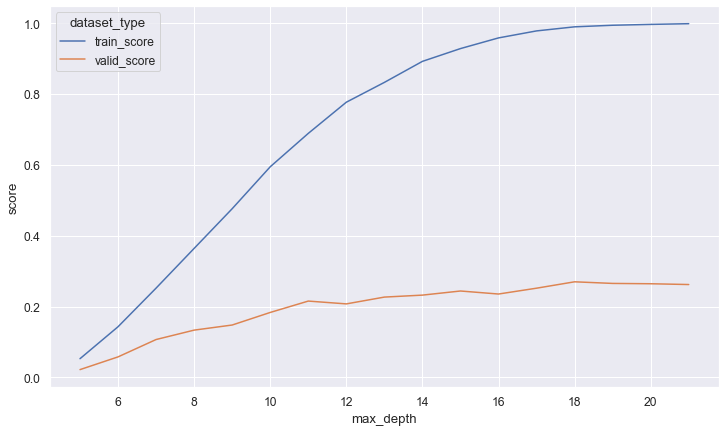

    max_depth  train_score  valid_score
13         18     0.990099     0.269822
14         19     0.994562     0.265258
15         20     0.996948     0.264327
16         21     0.998985     0.262102
12         17     0.978591     0.251799
10         15     0.928649     0.243842
11         16     0.958817     0.235294
9          14     0.892550     0.232210
8          13     0.833136     0.226650
6          11     0.689105     0.215385
7          12     0.777181     0.207426
5          10     0.594774     0.183267
4           9     0.476337     0.147743
3           8     0.364235     0.133333
2           7     0.252061     0.106782
1           6     0.142947     0.057751
0           5     0.052632     0.021773

Наилучший результат с параметрами:
max_depth      18.000000
train_score     0.990099
valid_score     0.269822
Name: 13, dtype: float64



In [40]:
find_depth(RandomForestClassifier, range(5, 22))

<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
max_depth = 5
	train_score = 0.0080808
	valid_score = 0.0000000

max_depth = 6
	train_score = 0.0345515
	valid_score = 0.0031496

max_depth = 7
	train_score = 0.0628684
	valid_score = 0.0155763

max_depth = 8
	train_score = 0.1302149
	valid_score = 0.0367534

max_depth = 9
	train_score = 0.1729463
	valid_score = 0.0572289

max_depth = 10
	train_score = 0.2455516
	valid_score = 0.0627803

max_depth = 11
	train_score = 0.3419283
	valid_score = 0.0795287

max_depth = 12
	train_score = 0.4088219
	valid_score = 0.0901163

max_depth = 13
	train_score = 0.4892748
	valid_score = 0.1212976

max_depth = 14
	train_score = 0.5619835
	valid_score = 0.1314685

max_depth = 15
	train_score = 0.6368664
	valid_score = 0.1276006



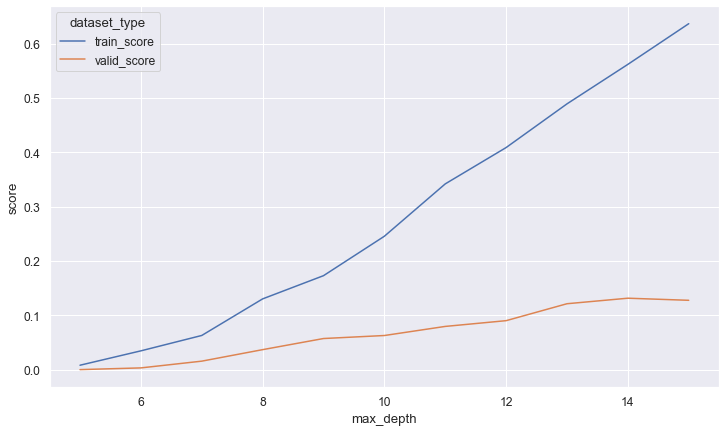

    max_depth  train_score  valid_score
9          14     0.561983     0.131469
10         15     0.636866     0.127601
8          13     0.489275     0.121298
7          12     0.408822     0.090116
6          11     0.341928     0.079529
5          10     0.245552     0.062780
4           9     0.172946     0.057229
3           8     0.130215     0.036753
2           7     0.062868     0.015576
1           6     0.034551     0.003150
0           5     0.008081     0.000000

Наилучший результат с параметрами:
max_depth      14.000000
train_score     0.561983
valid_score     0.131469
Name: 9, dtype: float64



In [41]:
find_depth(ExtraTreesClassifier, max_depth_values=range(5, 16))

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
max_depth = 2
	train_score = 0.2342857
	valid_score = 0.1917443

max_depth = 3
	train_score = 0.3556728
	valid_score = 0.2339623

max_depth = 4
	train_score = 0.5017115
	valid_score = 0.2663496

max_depth = 5
	train_score = 0.6498896
	valid_score = 0.3059361

max_depth = 6
	train_score = 0.7979066
	valid_score = 0.3182320

max_depth = 7
	train_score = 0.9010011
	valid_score = 0.3258307

max_depth = 8
	train_score = 0.9679219
	valid_score = 0.3166844



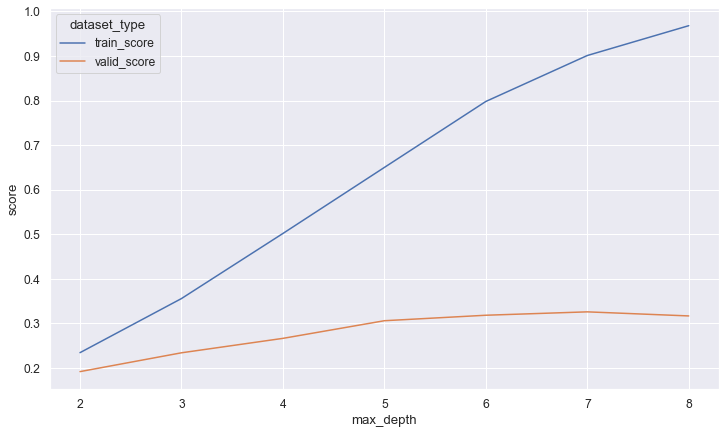

   max_depth  train_score  valid_score
5          7     0.901001     0.325831
4          6     0.797907     0.318232
6          8     0.967922     0.316684
3          5     0.649890     0.305936
2          4     0.501711     0.266350
1          3     0.355673     0.233962
0          2     0.234286     0.191744

Наилучший результат с параметрами:
max_depth      7.000000
train_score    0.901001
valid_score    0.325831
Name: 5, dtype: float64



In [42]:
find_depth(GradientBoostingClassifier, range(2, 9))

<class 'lightgbm.sklearn.LGBMClassifier'>
max_depth = 2
	train_score = 0.2164009
	valid_score = 0.1862348

max_depth = 3
	train_score = 0.3413613
	valid_score = 0.2391034

max_depth = 4
	train_score = 0.4610103
	valid_score = 0.2806604

max_depth = 5
	train_score = 0.5667752
	valid_score = 0.2996516

max_depth = 6
	train_score = 0.6792940
	valid_score = 0.3201754

max_depth = 7
	train_score = 0.7859734
	valid_score = 0.3440171

max_depth = 8
	train_score = 0.8413313
	valid_score = 0.3385580

max_depth = 9
	train_score = 0.8750472
	valid_score = 0.3357513

max_depth = 10
	train_score = 0.9222384
	valid_score = 0.3784902

max_depth = 11
	train_score = 0.9222384
	valid_score = 0.3537832



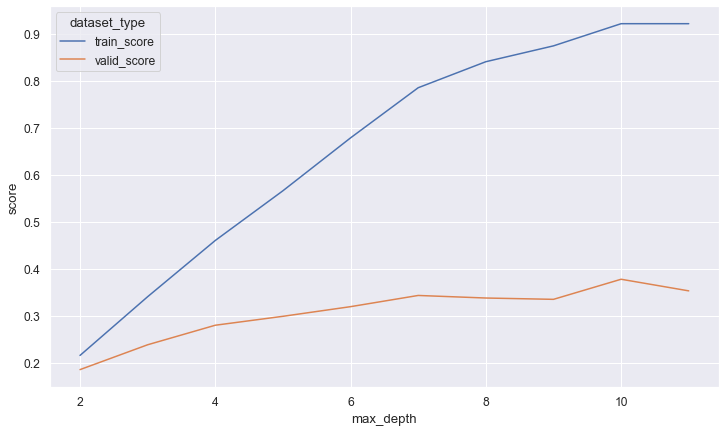

   max_depth  train_score  valid_score
8         10     0.922238     0.378490
9         11     0.922238     0.353783
5          7     0.785973     0.344017
6          8     0.841331     0.338558
7          9     0.875047     0.335751
4          6     0.679294     0.320175
3          5     0.566775     0.299652
2          4     0.461010     0.280660
1          3     0.341361     0.239103
0          2     0.216401     0.186235

Наилучший результат с параметрами:
max_depth      10.000000
train_score     0.922238
valid_score     0.378490
Name: 8, dtype: float64



In [43]:
find_depth(LGBMClassifier, range(2, 12), 1)

<class 'catboost.core.CatBoostClassifier'>
max_depth = 2
	train_score = 0.2606791
	valid_score = 0.2098446

max_depth = 3
	train_score = 0.3384453
	valid_score = 0.2303797

max_depth = 4
	train_score = 0.4279211
	valid_score = 0.2542787

max_depth = 5
	train_score = 0.5380228
	valid_score = 0.2636034

max_depth = 6
	train_score = 0.6672535
	valid_score = 0.2860492

max_depth = 7
	train_score = 0.7825377
	valid_score = 0.2764977

max_depth = 8
	train_score = 0.8926300
	valid_score = 0.2837684

max_depth = 9
	train_score = 0.9514357
	valid_score = 0.2805017



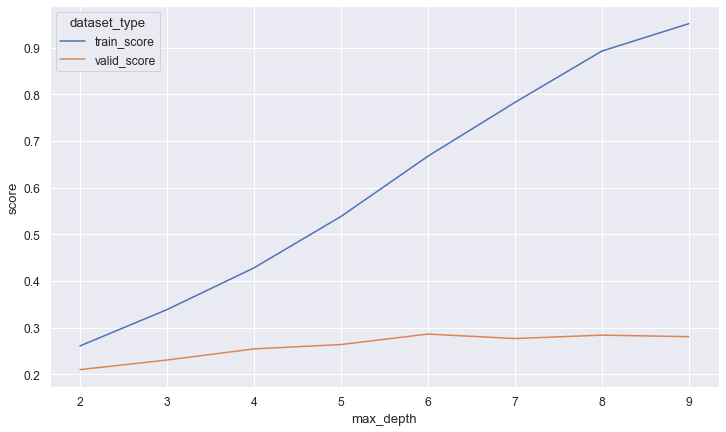

   max_depth  train_score  valid_score
4          6     0.667254     0.286049
6          8     0.892630     0.283768
7          9     0.951436     0.280502
5          7     0.782538     0.276498
3          5     0.538023     0.263603
2          4     0.427921     0.254279
1          3     0.338445     0.230380
0          2     0.260679     0.209845

Наилучший результат с параметрами:
max_depth      6.000000
train_score    0.667254
valid_score    0.286049
Name: 4, dtype: float64



In [44]:
find_depth(CatBoostClassifier, range(2, 10), 2)

### Анализируя полученные результаты: дальше будем работать с CatBoostClassifier

In [45]:
params = {
    'max_depth': range(4, 9),
    'iterations': range(30, 201, 10),
}

model = CatBoostClassifier(silent=True, random_state=SEED,
                           class_weights=[1, imbalance],
                           cat_features=category_columns,
                           eval_metric='F1',
                           early_stopping_rounds=30,
                           )

skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

grid_search = model.grid_search(params, X_train, y_train, cv=skf,
                                stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6068962771
bestIteration = 27

0:	loss: 0.6068963	best: 0.6068963 (0)	total: 128ms	remaining: 11.4s

bestTest = 0.6132354573
bestIteration = 34

1:	loss: 0.6132355	best: 0.6132355 (1)	total: 288ms	remaining: 12.7s

bestTest = 0.6234971356
bestIteration = 46

2:	loss: 0.6234971	best: 0.6234971 (2)	total: 423ms	remaining: 12.3s

bestTest = 0.6306917405
bestIteration = 50

3:	loss: 0.6306917	best: 0.6306917 (3)	total: 586ms	remaining: 12.6s

bestTest = 0.6306917405
bestIteration = 50

4:	loss: 0.6306917	best: 0.6306917 (3)	total: 783ms	remaining: 13.3s

bestTest = 0.6306917405
bestIteration = 50

5:	loss: 0.6306917	best: 0.6306917 (3)	total: 1s	remaining: 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6306917405
bestIteration = 50

6:	loss: 0.6306917	best: 0.6306917 (3)	total: 1.24s	remaining: 14.7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6306917405
bestIteration = 50

7:	loss: 0.6306917	best: 0.6306917 (3)	total: 1.47s	re


bestTest = 0.5994139779
bestIteration = 39

55:	loss: 0.5994140	best: 0.6417302 (40)	total: 11.5s	remaining: 6.97s

bestTest = 0.6081735862
bestIteration = 43

56:	loss: 0.6081736	best: 0.6417302 (40)	total: 11.7s	remaining: 6.77s

bestTest = 0.6086005515
bestIteration = 54

57:	loss: 0.6086006	best: 0.6417302 (40)	total: 11.9s	remaining: 6.59s

bestTest = 0.6086005515
bestIteration = 54

58:	loss: 0.6086006	best: 0.6417302 (40)	total: 12.3s	remaining: 6.45s

bestTest = 0.6086005515
bestIteration = 54

59:	loss: 0.6086006	best: 0.6417302 (40)	total: 12.6s	remaining: 6.32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6086005515
bestIteration = 54

60:	loss: 0.6086006	best: 0.6417302 (40)	total: 13s	remaining: 6.18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6086005515
bestIteration = 54

61:	loss: 0.6086006	best: 0.6417302 (40)	total: 13.4s	remaining: 6.05s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6086005515
bes

In [46]:
# лучшие параметры
grid_search['params']

{'depth': 6, 'iterations': 70}

In [47]:
final_model = model
final_model.fit(X_train, y_train)
evaluate_preds(final_model, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      3771
           1       0.51      0.82      0.63      1479

    accuracy                           0.73      5250
   macro avg       0.71      0.76      0.71      5250
weighted avg       0.80      0.73      0.74      5250

VALID

              precision    recall  f1-score   support

           0       0.82      0.62      0.71      1616
           1       0.40      0.65      0.50       634

    accuracy                           0.63      2250
   macro avg       0.61      0.64      0.60      2250
weighted avg       0.70      0.63      0.65      2250

CONFUSION MATRIX

col_0             0    1
CreditDefault           
0              1001  615
1               220  414


Есть небольшое переобучение (если считать статистики на всем трейне - переобучение меньше, результаты приведены в конце ноутбука). Обучим финальную модель на всём трейне и делаем предсказания на тесте.

In [48]:
final_model.best_score_

{'learn': {'Logloss': 0.5137458990514463, 'F1': 0.7721755743762883}}

In [49]:
final_model.learning_rate_

0.23960000276565552

In [50]:
final_model.fit(X, y)
submit = pd.read_csv(FILE_SAMPLE, index_col='Id')
submit['Credit Default'] = final_model.predict(test_df)
submit.to_csv(FILE_SUBMIT)

In [51]:
feat_imp_df = pd.DataFrame({'features': X.columns.values,
                            'importances': final_model.feature_importances_})
feat_imp_df.sort_values('importances', ascending=False, inplace=True)
feat_imp_df

features  importances
11          CurrentLoanAmount    26.469777
0                AnnualIncome    11.245556
15                calc_months     9.620969
14                CreditScore     9.246371
5           MaximumOpenCredit     8.019270
4        YearsOfCreditHistory     6.368318
13                MonthlyDebt     5.834093
10                       Term     5.477589
12       CurrentCreditBalance     4.780787
1           YearsInCurrentJob     4.151848
7   MonthsSinceLastDelinquent     3.369697
3        NumberOfOpenAccounts     3.201591
6      NumberOfCreditProblems     0.931997
9                     Purpose     0.799535
8                Bankruptcies     0.455101
2                    TaxLiens     0.027502

In [52]:
print_time(global_start_time)

Время обработки: 0 час 2 мин 35.1 сек


#### Подсчет статистик на всем трейне, остальная обработка данных такая же, переобучения нет.
Результаты на валидации чуть меньше обучения. Для предсказаний на Каггле я использовал этот подход.

In [53]:
make_model(0, 0)

Обработка данных
Время обработки: 0 час 0 мин 1.4 сек
Пропуски заполнены по группировкам:  ['YearsInCurrentJob=med_history_job, bins=7', 'rest_bal_group_mld_median', 'grp_purpose_cm_median', 'debt_group_ai_median', 'grp_purpose_cla_med_mean', 'NumberOfCreditProblems_cs_median']
Исходный размер датасета в памяти равен 3.81 мб.
Конечный размер датасета в памяти равен 1.01 мб.
Экономия памяти = 73.4%
CatGroups: ['grp_purpose', 'debt_group', 'rest_bal_group', 'NumberOfCreditProblems', 'HomeOwnership', 'purpose_term']
TargetEnc: ['TargetEnc_grp_purpose', 'TargetEnc_debt_group', 'TargetEnc_rest_bal_group', 'TargetEnc_NumberOfCreditProblems', 'TargetEnc_HomeOwnership', 'TargetEnc_purpose_term', 'TargetEnc_grp_purpose_debt_group', 'TargetEnc_grp_purpose_rest_bal_group', 'TargetEnc_grp_purpose_NumberOfCreditProblems', 'TargetEnc_grp_purpose_HomeOwnership', 'TargetEnc_grp_purpose_purpose_term', 'TargetEnc_debt_group_rest_bal_group', 'TargetEnc_debt_group_NumberOfCreditProblems', 'TargetEnc_debt_

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5947609172
bestIteration = 47

0:	loss: 0.5947609	best: 0.5947609 (0)	total: 1.12s	remaining: 14.5s

bestTest = 0.6187902958
bestIteration = 58

1:	loss: 0.6187903	best: 0.6187903 (1)	total: 1.34s	remaining: 8.02s

bestTest = 0.6254748329
bestIteration = 65

2:	loss: 0.6254748	best: 0.6254748 (2)	total: 1.55s	remaining: 5.68s

bestTest = 0.6254748329
bestIteration = 65

3:	loss: 0.6254748	best: 0.6254748 (2)	total: 1.78s	remaining: 4.46s

bestTest = 0.629594795
bestIteration = 86

4:	loss: 0.6295948	best: 0.6295948 (4)	total: 2.05s	remaining: 3.7s

bestTest = 0.631350617
bestIteration = 93

5:	loss: 0.6313506	best: 0.6313506 (5)	total: 2.39s	remaining: 3.19s

bestTest = 0.631350617
bestIteration = 93

6:	loss: 0.6313506	best: 0.6313506 (5)	total: 2.72s	remaining: 2.72s

bestTest = 0.631350617
bestIteration = 93

7:	loss: 0.6313506	best: 0.6313506 (5)	total: 3.08s	remaining: 2.31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.631350617
bestIteration =

In [54]:
print_time(global_start_time)

Время обработки: 0 час 2 мин 49.0 сек
